---

# *Initial* **Setup**

---

## **Library** *Settings*

The Real Package Name must be found in https://pypi.org

In [1]:
# Library Import
import pathlib
import os
import sys
import io
import gc
import math
import pickle
import psutil
import nilearn
import nibabel as nib
import numpy as np
import argparse
import pandas as pd
import h5py
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchsummary
import torchvision
import pytorch_lightning as pl
import pl_bolts                     # lightning_bolts
import tensorboard
import tensorflow as tf
import keras
import fvcore
import matplotlib.pyplot as plt
import itk
import itkwidgets
import time
import timeit
import warnings
import alive_progress

C:\Users\pfernan2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pl_bolts\callbacks\data_monitor.py:20: UnderReviewWarning: The feature warn_missing_pkg is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  warn_missing_pkg("wandb")
C:\Users\pfernan2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pl_bolts\models\self_supervised\amdim\amdim_module.py:35: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. Mor

In [2]:
# Functionality Import
from pathlib import Path
temp = pathlib.PosixPath
pathlib.PosixPath = pathlib.WindowsPath
from typing import List, Literal, Optional, Callable, Dict, Literal, Optional, Union, Tuple, Iterable
from collections import OrderedDict, namedtuple
from torch.utils.data import DataLoader, Dataset, TensorDataset
from sklearn.model_selection import train_test_split
from torch.nn.utils import spectral_norm
from torchsummary import summary
from pytorch_lightning.loggers import TensorBoardLogger
from pl_bolts.models.autoencoders.components import resnet18_encoder, resnet18_decoder
torch.autograd.set_detect_anomaly(True)
from sklearn.preprocessing import StandardScaler

from keras.models import Sequential
from keras.layers import Dense, Dropout, LeakyReLU, Layer, Softmax, Input
from keras import backend as K
from keras import Model
from keras.callbacks import EarlyStopping
from keras.initializers import Constant, glorot_normal
from keras.optimizers import Adam
from itertools import product
from datetime import datetime

from nilearn.image import load_img
from nilearn.masking import unmask
from PIL import Image
from ipywidgets import interactive, IntSlider
from tabulate import tabulate
from alive_progress import alive_bar
warnings.filterwarnings('ignore')

## **Control** *Station*

In [3]:
# Dataset Parametrizations Parser Initialization
data_parser = argparse.ArgumentParser(
        description = "1D MUDI Dataset Settings")
data_parser.add_argument(                               # Dataset Version Variable
        '--version', type = int,                        # Default: 0
        default = 2,
        help = "Dataset Save Version")
data_parser.add_argument(                               # Control Variable for the Usage of only 1 Voxel per Sample
        '--conversion', type = bool,                    # Default: True
        default = True,
        help = "Control Variable for the Usage of only 1 Voxel per Sample")
data_parser.add_argument(                               # Dataset Batch Size Value
        '--batch_size', type = int,                     # Default: 500
        default = 256,
        help = "Dataset Batch Size Value")

# --------------------------------------------------------------------------------------------

# Dataset Label Parametrization Arguments
data_parser.add_argument(                       # Control Variable for the Inclusion of Patient ID in Labels
        '--patient_id', type = bool,            # Default: True
        default = False,
        help = "Control Variable for the Inclusion of Patient ID in Labels")
data_parser.add_argument(                       # Control Variable for the Conversion of 3 Gradient Directions
        '--gradient_coord', type = bool,        # Coordinates into 2 Gradient Direction Angles (suggested by prof. Chantal)
        default = False,                        # Default: True (3 Coordinate Gradient Values)
        help = "Control Variable for the Conversion of Gradient Direction Mode")
data_parser.add_argument(                       # Control Variable for the Rescaling & Normalization of Labels
        '--label_norm', type = bool,            # Default: True
        default = True,
        help = "Control Variable for the Rescaling & Normalization of Labels")
data_settings = data_parser.parse_args("")
num_labels = 7
if not(data_settings.patient_id): num_labels -= 1           # Exclusion of Patiend ID
if not(data_settings.gradient_coord): num_labels -= 1       # Conversion of Gradient Coordinates to Angles
data_parser.add_argument(                                   # Dataset Number of Labels
        '--num_labels', type = int,                         # Default: 7
        default = num_labels,
        help = "MUDI Dataset Number of Labels")

# --------------------------------------------------------------------------------------------

# Addition of File & Folderpath Arguments
data_parser.add_argument(                               # Path for Main Dataset Folder
        '--main_folderpath', type = str,
        default = '../../../Datasets/MUDI Dataset',
        help = 'Main Folderpath for Root Dataset')
data_settings = data_parser.parse_args("")
data_parser.add_argument(                               # Path for Parameter Value File
        '--param_filepath', type = Path,
        default = Path(f'{data_settings.main_folderpath}/Raw Data/parameters_new.xlsx'),
        help = 'Input Filepath for Parameter Value Table')
data_parser.add_argument(                               # Path for Parameter Value File
        '--data_filepath', type = Path,
        default = Path(f'{data_settings.main_folderpath}/Raw Data/data_.hdf5'),
        help = 'Input Filepath for Parameter Value Table')
data_parser.add_argument(                               # Path for Patient Information File
        '--info_filepath', type = Path,
        default = Path(f'{data_settings.main_folderpath}/Raw Data/header1_.csv'),
        help = 'Input Filepath for Patient Information Table')
data_parser.add_argument(                               # Path for Folder Containing Patient Data Files
        '--patient_folderpath', type = Path,
        default = Path(f'{data_settings.main_folderpath}/Patient Data'),
        help = 'Input Folderpath for Segregated Patient Data')
data_parser.add_argument(                               # Path for Folder Containing Mask Data Files
        '--mask_folderpath', type = Path,
        default = Path(f'{data_settings.main_folderpath}/Patient Mask'),
        help = 'Input Folderpath for Segregated Patient Mask Data')
data_parser.add_argument(                               # Path for Dataset Saved Files
        '--save_folderpath', type = Path,
        default = Path(f'{data_settings.main_folderpath}/Saved Data/V{data_settings.version}'),
        help = 'Output Folderpath for MUDI Dataset Saved Versions')

# --------------------------------------------------------------------------------------------

# Dataset Splitting Arguments
data_parser.add_argument(                       # Number of Patients to be used in the Test Set
        '--test_patients', type = int,          # Default: 1
        default = 1,
        help = "Number of Patients in Test Set")
data_parser.add_argument(                       # Number / Percentage of Parameters for Training Set's Training
        '--train_params', type = int,           # Default: 500
        default = 500,
        help = "Number / Percentage of Patients in the Training of the Training Set")

# --------------------------------------------------------------------------------------------

# Boolean Control Input & Shuffling Arguments
data_parser.add_argument(                       # Control Variable for the Usage of Percentage Values in Parameters
        '--percentage', type = bool,            # Default: False
        default = False,
        help = "Control Variable for the Usage of Percentage Values in Parameters")
data_parser.add_argument(                       # Ability to Shuffle the Patients that compose both Training and Test Sets
        '--patient_shuffle', type = bool,       # Default: False
        default = False,
        help = "Ability to Shuffle the Patients that compose both Training and Test Sets")
data_parser.add_argument(                       # Ability to Shuffle the Samples inside both Training and Validation Sets
        '--sample_shuffle', type = bool,        # Default: False
        default = False,
        help = "Ability to Shuffle the Samples inside both Training and Validation Sets")
data_parser.add_argument(                       # Number of Workers for DataLoader Usage
        '--num_workers', type = int,                # Default: 1
        default = 20,
        help = "Number of Workers for DataLoader Usage")
data_settings = data_parser.parse_args("")

In [177]:
# Voxel-Wise CVAE Model Parametrizations Parser Initialization
model_parser = argparse.ArgumentParser(
        description = "Voxel-Wise CVAE Settings")
model_parser.add_argument(              # Model Version Variable
        '--model_version', type = int,  # Default: 0
        default = 2,
        help = "Experiment Version")
model_parser.add_argument(              # Dataset Version Variable
        '--data_version', type = int,   # Default: 0
        default = 0,
        help = "MUDI Dataset Version")

# --------------------------------------------------------------------------------------------

# Addition of Filepath Arguments
model_parser.add_argument(
        '--reader_folderpath', type = Path,
        default = Path(f'{data_settings.main_folderpath}/Dataset Reader'),
        help = 'Input Folderpath for MUDI Dataset Reader')
model_parser.add_argument(
        '--data_folderpath', type = Path,
        default = Path(f'{data_settings.main_folderpath}/Saved Data/V{data_settings.version}'),
        help = 'Input Folderpath for MUDI Dataset Saved Versions')
model_parser.add_argument(
        '--model_folderpath', type = str,
        default = 'Model Builds',
        help = 'Input Folderpath for Model Build & Architecture')
model_parser.add_argument(
        '--script_folderpath', type = str,
        default = 'Training Scripts',
        help = 'Input Folderpath for Training & Testing Script Functions')
model_parser.add_argument(
        '--save_folderpath', type = str,
        default = 'Saved Models',
        help = 'Output Folderpath for Saved & Saving Models')

# --------------------------------------------------------------------------------------------

# Addition of Training Requirement Arguments
model_parser.add_argument(              # Number of Epochs
        '--num_epochs', type = int,     # Default: 1
        default = 50,
        help = "Number of Epochs in Training Mode")
model_parser.add_argument(              # Base Learning Rate
        '--base_lr', type = float,      # Default: 1e-4
        default = 1e-3,
        help = "Base Learning Rate Value in Training Mode")
model_parser.add_argument(              # Weight Decay Value
        '--weight_decay', type = float, # Default: 0.0001
        default = 1e-4,
        help = "Weight Decay Value in Training Mode")
model_parser.add_argument(              # Learning Rate Decay Ratio
        '--lr_decay', type = float,     # Default: 0.9
        default = 0.9,
        help = "Learning Rate Decay Value in Training Mode")
        
# --------------------------------------------------------------------------------------------

# Addition of Model Architecture Arguments
model_parser.add_argument(              # Dataset Number of Labels
        '--num_labels', type = int,     # Default: 7
        default = data_settings.num_labels,
        help = "MUDI Dataset Number of Labels")
model_parser.add_argument(              # Latent Space Dimensionality
        '--latent_dim', type = int,     # Default: 128
        default = 128,
        help = "Latent Space Dimensionality Value")
model_parser.add_argument(              # Number of Reference Channels for Encoder Architecture
        '--num_channel', type = int,    # Default: 64
        default = 64,
        help = "Number of Reference Channels for Encoder Architecture")
model_parser.add_argument(              # Number of Main Layers in Encoder & Decoder Architectures
        '--num_layers', type = int,     # Default: 3
        default = 3,
        help = "Number of Main Layers in Encoder & Decoder Architectures")
"""
model_parser.add_argument(              # Convolutional Layer Expansion Value
        '--expansion', type = int,      # Default: 1
        default = 1,
        help = "Convolutional Layer Expansion Value")
model_parser.add_argument(              # Kullback-Leibler Loss Weight
        '--kl_alpha', type = int,       # Default: 1
        default = 1,
        help = "Kullback-Leibler Loss Weight")
if data_settings.dim == 2: num_channel = 1
else: num_channel = data_settings.num_slices
model_parser.add_argument(              # Number of Channels in given 3D Image Batch
        '--num_channel', type = int,    # Default: 1 (for 2D MUDI Dataset)
        default = num_channel,
        help = "Number of Channels in given 3D Image Batch")
model_parser.add_argument(              # Image Side Length (No Support for non-Square Images)
        '--img_shape', type = int,      # Default: 128 
        default = data_settings.img_shape[-1],
        help = "Image Side Length")
"""

model_settings = model_parser.parse_args("")
model_settings.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [24]:
# Voxel-Wise Conditional Linear Neural Network Model Parametrizations Parser Initialization
model_parser = argparse.ArgumentParser(
        description = "Voxel-Wise clNN Settings")
model_parser.add_argument(              # Model Version Variable
        '--model_version', type = int,  # Default: 0
        default = 4,
        help = "Experiment Version")
model_parser.add_argument(              # Dataset Version Variable
        '--data_version', type = int,   # Default: 0
        default = 0,
        help = "MUDI Dataset Version")

# --------------------------------------------------------------------------------------------

# Addition of Filepath Arguments
model_parser.add_argument(
        '--reader_folderpath', type = Path,
        default = Path(f'{data_settings.main_folderpath}/Dataset Reader'),
        help = 'Input Folderpath for MUDI Dataset Reader')
model_parser.add_argument(
        '--data_folderpath', type = Path,
        default = Path(f'{data_settings.main_folderpath}/Saved Data/V{data_settings.version}'),
        help = 'Input Folderpath for MUDI Dataset Saved Versions')
model_parser.add_argument(
        '--model_folderpath', type = str,
        default = 'Model Builds',
        help = 'Input Folderpath for Model Build & Architecture')
model_parser.add_argument(
        '--script_folderpath', type = str,
        default = 'Training Scripts',
        help = 'Input Folderpath for Training & Testing Script Functions')
model_parser.add_argument(
        '--save_folderpath', type = str,
        default = 'Saved Models',
        help = 'Output Folderpath for Saved & Saving Models')

# --------------------------------------------------------------------------------------------

# Addition of Training Requirement Arguments
model_parser.add_argument(              # Number of Epochs
        '--num_epochs', type = int,     # Default: 1
        default = 50,
        help = "Number of Epochs in Training Mode")
model_parser.add_argument(              # Base Learning Rate
        '--base_lr', type = float,      # Default: 1e-4
        default = 1e-3,
        help = "Base Learning Rate Value in Training Mode")
model_parser.add_argument(              # Weight Decay Value
        '--weight_decay', type = float, # Default: 0.0001
        default = 1e-4,
        help = "Weight Decay Value in Training Mode")
model_parser.add_argument(              # Learning Rate Decay Ratio
        '--lr_decay', type = float,     # Default: 0.9
        default = 0.9,
        help = "Learning Rate Decay Value in Training Mode")
        
# --------------------------------------------------------------------------------------------

# Addition of Model Architecture Arguments
model_parser.add_argument(              # Dataset Number of Labels
        '--num_labels', type = int,     # Default: 7
        default = data_settings.num_labels,
        help = "MUDI Dataset Number of Labels")
model_parser.add_argument(              # Input Parameters
        '--in_params', type = int,      # Default: 500
        default = 500,
        help = "Input Parameters")
model_parser.add_argument(              # Output Parameters
        '--out_params', type = int,     # Default: 1344
        default = 1344,
        help = "Output Parameters")
model_parser.add_argument(              # Latent Space Dimensionality
        '--latent_dim', type = int,     # Default: 128
        default = 128,
        help = "Latent Space Dimensionality Value")
model_parser.add_argument(              # Number of Decoder Hidden Layers
        '--num_hidden', type = int,    # Default: 64
        default = 2,
        help = "Number of Decoder Hidden Layers")
model_parser.add_argument(              # Leaky ReLU Negative Slope Value
        '--neg_slope', type = float,    # Default: 0.2
        default = 0.2,
        help = "Leaky ReLU Negative Slope Value")

# --------------------------------------------------------------------------------------------

# Addition of Buffer Parameter Arguments
model_parser.add_argument(                      # Maximum Temperature for Gumble Softmax
        '--max_temp', type = float,             # Default: 10
        default = 10.0,
        help = "Maximum Temperature for Gumble Softmax")
model_parser.add_argument(                      # Minimum Temperature for Gumble Softmax
        '--min_temp', type = float,             # Default: 0.1
        default = 0.1,
        help = "Minimum Temperature for Gumble Softmax")
model_parser.add_argument(                      # Regularization Epsilon
        '--reg_eps', type = float,              # Default: 1e-10
        default = 1e-10,
        help = "Regularization Epsilon - Minimum Value for the Clamped Softmax in Regularization")
model_parser.add_argument(                      # Regularization Threshold
        '--reg_threshold', type = float,        # Default: 3.0
        default = 1.0,
        help = "Regularization Threshold - Value for which the Sum of Neuron Probabilities will mean the Penalization of the Encoder")
model_parser.add_argument(                      # Regularization Lambda
        '--reg_lambda', type = float,           # Default: 0 (No Regularization)
        default = 0.0,
        help = "Regularization Lambda - Regularization Term Weight")

model_settings = model_parser.parse_args("")
model_settings.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [220]:
# Fully Connected Neural Network Model Parametrizations Parser Initialization
model_parser = argparse.ArgumentParser(
        description = "fcNN Settings")
model_parser.add_argument(              # Model Version Variable
        '--model_version', type = int,  # Default: 0
        default = 0,
        help = "Experiment Version")
model_parser.add_argument(              # Dataset Version Variable
        '--data_version', type = int,   # Default: 0
        default = 1,
        help = "MUDI Dataset Version")

# --------------------------------------------------------------------------------------------

# Addition of Filepath Arguments
model_parser.add_argument(
        '--reader_folderpath', type = Path,
        default = Path(f'{data_settings.main_folderpath}/Dataset Reader'),
        help = 'Input Folderpath for MUDI Dataset Reader')
model_parser.add_argument(
        '--data_folderpath', type = Path,
        default = Path(f'{data_settings.main_folderpath}/Saved Data/V{data_settings.version}'),
        help = 'Input Folderpath for MUDI Dataset Saved Versions')
model_parser.add_argument(
        '--model_folderpath', type = str,
        default = 'Model Builds',
        help = 'Input Folderpath for Model Build & Architecture')
model_parser.add_argument(
        '--script_folderpath', type = str,
        default = 'Training Scripts',
        help = 'Input Folderpath for Training & Testing Script Functions')
model_parser.add_argument(
        '--save_folderpath', type = str,
        default = 'Saved Models',
        help = 'Output Folderpath for Saved & Saving Models')

# --------------------------------------------------------------------------------------------

# Addition of Training Requirement Arguments
model_parser.add_argument(              # Number of Epochs
        '--num_epochs', type = int,     # Default: 1
        default = 50,
        help = "Number of Epochs in Training Mode")
model_parser.add_argument(              # Base Learning Rate
        '--base_lr', type = float,      # Default: 1e-3
        default = 1e-3,
        help = "Base Learning Rate Value in Training Mode")
model_parser.add_argument(              # Weight Decay Value
        '--weight_decay', type = float, # Default: 1e-4
        default = 1e-4,
        help = "Weight Decay Value in Training Mode")
model_parser.add_argument(              # Learning Rate Decay Ratio
        '--lr_decay', type = float,     # Default: 0.9
        default = 0.9,
        help = "Learning Rate Decay Value in Training Mode")
        
# --------------------------------------------------------------------------------------------

# Addition of Model Architecture Arguments
model_parser.add_argument(              # Dataset Number of Labels
        '--num_labels', type = int,     # Default: 7
        default = data_settings.num_labels,
        help = "MUDI Dataset Number of Labels")
model_parser.add_argument(              # Number of Parameter Settings for Training
        '--in_params', type = int,      # Default: 500
        default = data_settings.train_params,
        help = "Number of Parameter Settings for Training")
model_parser.add_argument(              # Total Number of Parameter Settings
        '--out_params', type = int,     # Default: 1344
        default = 1344,
        help = "Total Number of Parameter Settings")
model_parser.add_argument(              # Number of Hidden Layers in Neural Network
        '--num_hidden', type = int,     # Default: 2
        default = 2,
        help = "Number of Hidden Layers in Neural Network")

model_settings = model_parser.parse_args("")
model_settings.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Conditional Generative Linear Voxel Neural Network Model Parametrizations Parser Initialization
model_parser = argparse.ArgumentParser(
        description = "cglVNN Settings")
model_parser.add_argument(              # Model Version Variable
        '--model_version', type = int,  # Default: 0
        default = 3,
        help = "Experiment Version")
model_parser.add_argument(              # Dataset Version Variable
        '--data_version', type = int,   # Default: 0
        default = 2,
        help = "MUDI Dataset Version")

# --------------------------------------------------------------------------------------------

# Addition of Filepath Arguments
model_parser.add_argument(
        '--reader_folderpath', type = Path,
        default = Path(f'{data_settings.main_folderpath}/Dataset Reader'),
        help = 'Input Folderpath for MUDI Dataset Reader')
model_parser.add_argument(
        '--data_folderpath', type = Path,
        default = Path(f'{data_settings.main_folderpath}/Saved Data/V{data_settings.version}'),
        help = 'Input Folderpath for MUDI Dataset Saved Versions')
model_parser.add_argument(
        '--model_folderpath', type = str,
        default = 'Model Builds',
        help = 'Input Folderpath for Model Build & Architecture')
model_parser.add_argument(
        '--script_folderpath', type = str,
        default = 'Training Scripts',
        help = 'Input Folderpath for Training & Testing Script Functions')
model_parser.add_argument(
        '--save_folderpath', type = str,
        default = 'Saved Models',
        help = 'Output Folderpath for Saved & Saving Models')

# --------------------------------------------------------------------------------------------

# Addition of Training Requirement Arguments
model_parser.add_argument(              # Number of Epochs
        '--num_epochs', type = int,     # Default: 1
        default = 50,
        help = "Number of Epochs in Training Mode")
model_parser.add_argument(              # Base Learning Rate
        '--base_lr', type = float,      # Default: 1e-3
        default = 1e-3,
        help = "Base Learning Rate Value in Training Mode")
model_parser.add_argument(              # Weight Decay Value
        '--weight_decay', type = float, # Default: 1e-4
        default = 1e-4,
        help = "Weight Decay Value in Training Mode")
model_parser.add_argument(              # Learning Rate Decay Ratio
        '--lr_decay', type = float,     # Default: 0.9
        default = 0.9,
        help = "Learning Rate Decay Value in Training Mode")
        
# --------------------------------------------------------------------------------------------

# Addition of Model Architecture Arguments
model_parser.add_argument(              # Dataset Number of Labels
        '--num_labels', type = int,     # Default: 7
        default = data_settings.num_labels,
        help = "MUDI Dataset Number of Labels")
model_parser.add_argument(              # Number of Hidden Layers in Neural Network
        '--num_hidden', type = int,     # Default: 2
        default = 2,
        help = "Number of Hidden Layers in Neural Network")
model_parser.add_argument(              # Deviance / Expansion of Hidden Layers
        '--var_hidden', type = int,     # Default: 64
        default = 64,
        help = "Deviance / Expansion of Hidden Layers")

model_settings = model_parser.parse_args("")
model_settings.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

---

# **Data** *Access*

---

In [56]:
# Horizontal 1D MUDI Dataset Initialization Class
class h1DMUDI(Dataset):

    # Constructor / Initialization Function
    def __init__(
        self,
        settings: argparse.ArgumentParser
    ):

        # Parameter Value Access
        super(h1DMUDI).__init__()
        self.version = settings.version
        self.params = pd.read_excel(settings.param_filepath)    # List of Dataset's Parameters
        self.num_params = self.params.shape[0]                  # Total Number of Parameters in Dataset
        #assert(self.num_params == self.data.shape[0]), "ERROR: Number of Parameters is Incoherent" 

        # Patient Information Access
        self.patient_folderpath = settings.patient_folderpath
        self.save_folderpath = settings.save_folderpath
        self.patient_info = pd.read_csv(settings.info_filepath)     # List of Patients and Corresponding IDs & Image Sizes inside Full Dataset
        self.patient_info = self.patient_info[:-1]                  # Eliminating the Last Row containing Useless Information from the Patient Information
        self.num_patients = self.patient_info.shape[0]              # Number of Patients inside Full Dataset
        self.progress = False                                       # Control Boolean Value for Progress Saving (Data can only be saved if Split)
        
        # Dataset Sample & Label Handling Settings
        self.num_labels = settings.num_labels
        if self.settings.gradient_coord: self.params = self.params.drop(columns = ['Gradient theta', 'Gradient phi'])   # Choosing of Gradient Orientation
        else: self.params = self.params.drop(columns = ['Gradient x', 'Gradient y', 'Gradient z'])                      # from 3D Cartesian or Polar Referential
        assert(self.params.shape[1] == self.num_labels), "ERROR: Labels wrongly Deleted!"
        if self.settings.label_norm:                                                                                    # Control Boolean Value for the Normalization of Labels
            self.scaler = StandardScaler()
            self.params = pd.DataFrame( self.scaler.fit_transform(self.params),
                                        columns = self.params.columns)

    ##############################################################################################
    # --------------------------------- Feature & Label Handling ---------------------------------
    ##############################################################################################

    # 1D Image to 1D Voxel Data Conversion Function
    # [num_sample, num_feats] -> [num_sample * num_feats, 1]
    def convert(
        self,
        data: np.ndarray,           # 3D Data Array
        label: pd.DataFrame
    ):

        # Conversion from 1D Image Data to 1D Voxel Data
        label = label.iloc[np.repeat(np.arange(len(label)), data.shape[1])]
        data = pd.DataFrame(data.to_numpy().reshape((data.shape[0] * data.shape[1], 1)))
        return data, label

    # ----------------------------------------------------------------------------------------------------------------------------

    # Full 3D Patient Image Unmasking
    def unmask(
        settings: argparse.ArgumentParser,
        patient_number: int                     # Number for the Patient File being Read and Acquired (in Order)
    ):

        # Patient Mask Access
        mask_filepath = Path(f"{settings.mask_folderpath}/p{patient_id}.nii")               # Mask Filepath from detailed Folder
        assert(mask_filepath.exists()                                                       # Assertion for the Existence of Mask File in said Folder
        ), f"Filepath for Mask {patient_id} is not in the Dataset!"

        # Patient Data Access
        data = load(settings.save_folderpath, settings.version)
        pX = data.get_patient(patient_number)
        pX = unmask(pX, pMask); pX = pX.get_fdata()     # Unmasking of Full Patient Data
        
    
    # ----------------------------------------------------------------------------------------------------------------------------

    # Label Scaler Download & Reverse Transformation
    def label_unscale(
        path: Path,
        version: int,
        y: np.array or pd.DataFrame
    ):

        # Label Scaler Download & Reverse Usage
        scaler = torch.load(f"{path}/1D Label Scaler (V{version}).pkl")
        return scaler.inverse_transform(y)
        
    ##############################################################################################
    # ---------------------------------- Data Access & Splitting ---------------------------------
    ##############################################################################################

    # Patient Data Access Function
    def get_patient(
        self,
        patient_number: int,                # Number for the Patient File being Read and Acquired (in Order)
    ):

        # Patient Data Information
        assert(0 <= patient_number < self.num_patients), f"ERROR: Input Patient not Found!"         # Assertion for the Existence of the Requested Patient
        patient_id = self.patient_info['Patient'].iloc[patient_number]                              # Patient ID contained within the Patient List
        patient_filepath = Path(f"{self.patient_folderpath}/p{patient_id}.csv")                     # Patient Filepath from detailed Folder
        mask_filepath = Path(f"{self.mask_folderpath}/p{patient_id}.nii")                           # Mask Filepath from detailed Folder
        
        # Patient Data Access Memory Requirements
        assert(patient_filepath.exists()                                                            # Assertion for the Existence of Patient File in said Folder
        ), f"Filepath for Patient {patient_id} is not in the Dataset!"
        assert(mask_filepath.exists()                                                               # Assertion for the Existence of Mask File in said Folder
        ), f"Filepath for Mask {patient_id} is not in the Dataset!"
        file_size = os.path.getsize(patient_filepath)                                               # Memory Space occupied by Patient File
        mask_size = os.path.getsize(mask_filepath)                                                  # Memory Space occupied by Mask File
        available_memory = psutil.virtual_memory().available                                        # Memory Space Available for Computation
        assert(available_memory >= (file_size + mask_size)                                          # Assertion for the Existence of Available Memory Space
        ), f"ERROR: Dataset requires {file_size + mask_size}b, but only {available_memory}b is available!"
        
        # Patient Data Access
        pX = pd.read_csv(patient_filepath); del pX['Unnamed: 0']                                    # Full Patient Data
        pMask = load_img(mask_filepath)                                                             # Patient Mask Data
        #pX = unmask(pX, pMask); pX = pX.get_fdata()                                                # Unmasking of Full Patient Data
        del available_memory, mask_size, file_size
        return pX, pMask

    # ----------------------------------------------------------------------------------------------------------------------------
    
    # Patient Data Splitting Function
    def split_patient(
        self,
        patient_number: int,                # Number for the Patient File being Read and Acquired (in Order)
        train_params: int = 500,            # Number / Percentage of Parameters to be used in the Training Section of the Patient
        percentage: bool = False,           # Control Variable for the Usage of Percentage Values in train_params
        sample_shuffle: bool = False,       # Ability to Shuffle the Samples inside both Training and Validation Datasets
    ):

        # Computation of Training & Validation Parameter Numbers (Percentage Input)
        if(percentage):
            assert(0 < train_params <= 100                              # Percentage Limits for Number of Training Parameters
            ), f"ERROR: Training Parameter Number not Supported!"
            train_params = train_params / 100                           # Percentage Value for Training Parameters
            val_params = 1 - train_params                               # Percentage Value for Validation Parameters

        # Computation of Training & Validation Parameter Numbers (Numerical Input)
        else:
            assert(0 < train_params <= self.num_params                  # Numerical Limits for Number of Training Parameters
            ), f"ERROR: Training Parameter Number not Supported!"
            val_params = self.num_params - train_params                 # Numerical Value for Validation Parameters
            if self.voxel_wise:                                         # Correction of Vaidation Parameter Number for Voxel-Wise Data
                patient_feats = self.patient_info['Voxels'].iloc[patient_number]
                val_params *= patient_feats

        # ----------------------------------------------------------------------------------------------------------------------------

        # Patient Data & Label Access & Handling
        pX = self.get_patient(patient_number); py = self.params                                     # Patient Data Access
        if self.patient_id: py['Patient'] = self.patient_info['Patient'].iloc[patient_number]       # Patient ID Label Handling
        if self.voxel_wise: pX, py = self.convert(pX, py)                                           # 1D Image to Voxel Data Conversion

        # Patient Dataset Splitting into Training & Validation Sets
        if val_params != 0:
            pX_train, pX_val, py_train, py_val = train_test_split(  pX, py,
                                                                    test_size = val_params,
                                                                    shuffle = sample_shuffle,
                                                                    random_state = 42)
            return pX_train, pX_val, py_train, py_val
        else: return pX, py

    # ----------------------------------------------------------------------------------------------------------------------------

    # Dataset Splitting Function
    def split(
        self,
        settings: argparse.ArgumentParser
    ):

        # Patient Number Variable Logging
        assert(0 < settings.test_patients <= self.num_patients      # Limits for Number of Test Set Patients
        ), f"ERROR: Test Patient Number not Supported!"
        self.train_patients = self.num_patients - settings.test_patients    # Number of Patients to be used in the Training Set
        self.test_patients = settings.test_patients                         # Number of Patients to be used in the Test Set
        self.batch_size = settings.batch_size                               # Sample Batch Size Variable
        self.patient_shuffle = settings.patient_shuffle                     # Ability to Shuffle the Patients that compose both Training / Validation and Test Datasets
        self.sample_shuffle = settings.sample_shuffle                       # Ability to Shuffle the Samples inside both Training / Validation and Test Datasets
        self.num_workers = settings.num_workers                             # Number of Workers in the Usage of DataLoaders
        self.progress = True                                                # Control Boolean Value for Progress Saving (Data can only be saved if Split)
        
        # ----------------------------------------------------------------------------------------------------------------------------
        
        # Patient Shuffling Feature
        if(self.patient_shuffle): self.patient_info = self.patient_info.iloc[np.random.permutation(len(self.patient_info))]

        # Computation of Training & Validation Parameter Numbers (Percentage Input)
        if(settings.percentage):
            assert(0 < settings.train_params <= 100                         # Percentage Limits for Number of Training Set's Parameters
            ), f"ERROR: Training Set's Parameter Number not Supported!"
            self.trainTrain_params = settings.train_params                  # Percentage Value for Training Set's Training Parameters
            self.trainVal_params = 100 - settings.train_params              # Percentage Value for Training Set's Validation Parameters
            self.testTrain_params = 100                                     # Percentage Value for Test Set's Training Parameters
            self.testVal_params = 100 - self.testTrain_params               # Percentage Value for Test Set's Validation Parameters

        # Computation of Training & Validation Parameter Numbers (Percentage Input)
        else:
            assert(0 < settings.train_params <= self.num_params             # Numerical Limits for Number of Training Set's Parameters
            ), f"ERROR: Training Set's Parameter Number not Supported!"
            self.trainTrain_params = settings.train_params                  # Numerical Value for Training Set's Training Parameters
            self.trainVal_params = self.num_params - settings.train_params  # Numerical Value for Training Set's Validation Parameters
            self.testTrain_params = self.num_params                         # Numerical Value for Test Set's Training Parameters
            self.testVal_params = self.num_params - self.testTrain_params   # Numerical Value for Test Set's Validation Parameters

        # ----------------------------------------------------------------------------------------------------------------------------

        # Full MUDI Dataset Building
        with alive_bar( self.num_patients,
                        title = '1D MUDI Dataset',
                        force_tty = True) as progress_bar:

            # Training Set Scaffold Setting
            #self.train_set = dict.fromkeys(('X_train', 'X_val', 'y_train', 'y_val'))
            if self.voxel_wise:
                X_train = np.empty(list(np.array((0, 1))))
                X_val = np.empty(list(np.array((0, 1))))
            else:
                X_train = np.empty(list(np.array((0, settings.num_voxels))))
                X_val = np.empty(list(np.array((0, settings.num_voxels))))
            y_train = np.empty([0, self.num_labels]); y_val = np.empty([0, self.num_labels])

            # Training Set Building / Training Patient Loop
            for p in range(self.train_patients):

                # Training Patient Data Access & Treatment
                progress_bar.text = f"\n-> Training Set | Patient {self.patient_info['Patient'].iloc[p]}"
                pX_train, pX_val, py_train, py_val = self.split_patient(patient_number = p,
                                                                        train_params = self.trainTrain_params,
                                                                        percentage = settings.percentage,
                                                                        sample_shuffle = self.sample_shuffle)
                X_train = np.concatenate((X_train, pX_train), axis = 0); X_val = np.concatenate((X_val, pX_val), axis = 0)
                y_train = np.concatenate((y_train, py_train), axis = 0); y_val = np.concatenate((y_val, py_val), axis = 0)
                time.sleep(0.01); progress_bar()
            
            # Training DataLoader Construction
            #self.train_set['X_train'] = X_train; self.train_set['X_val'] = X_val
            #self.train_set['y_train'] = y_train; self.train_set['y_val'] = y_val
            self.trainTrainLoader = DataLoader(TensorDataset(   torch.Tensor(X_train),
                                                                torch.Tensor(y_train)),
                                                                num_workers = self.num_workers,
                                                                batch_size = self.batch_size, shuffle = False)
            self.trainValLoader = DataLoader(TensorDataset(     torch.Tensor(X_val),
                                                                torch.Tensor(y_val)),
                                                                num_workers = self.num_workers,
                                                                batch_size = self.batch_size, shuffle = False)
            del X_train, X_val, y_train, y_val, pX_train, pX_val, py_train, py_val

            # ----------------------------------------------------------------------------------------------------------------------------

            # Test Set Scaffold Setting
            #self.test_set = dict.fromkeys(('X', 'y'))                       # Creation of Empty Dictionary to Fit Patient Data
            if self.voxel_wise: X = np.empty(list(np.array((0, 1))))
            else: X = np.empty(list(np.array((0, settings.num_voxels))))
            y = np.empty([0, self.num_labels])

            # Test Set Building / Test Patient Loop
            for p in range(self.train_patients, self.train_patients + self.test_patients):

                # Test Patient Data Access & Treatment
                progress_bar.text = f"-> Test Set | Patient {self.patient_info['Patient'].iloc[p]}"
                pX, py = self.split_patient(patient_number = p,
                                            train_params = self.testTrain_params,
                                            percentage = settings.percentage,
                                            sample_shuffle = self.sample_shuffle)
                X = np.concatenate((X, pX), axis = 0); y = np.concatenate((y, py), axis = 0)
                print(X.shape)
                time.sleep(0.01); progress_bar()

            # Test DataLoader Construction
            #self.test_set['X'] = X; self.test_set['y'] = y
            self.testLoader = DataLoader(TensorDataset( torch.Tensor(X),
                                                        torch.Tensor(y)),
                                                        num_workers = self.num_workers,
                                                        batch_size = self.batch_size, shuffle = False)
            del X, y, pX, py

    ##############################################################################################
    # ------------------------------------- Saving & Loading -------------------------------------
    ##############################################################################################

    # Dataset Saving Function
    def save(self):
        if self.progress:

            # Full Dataset Saving
            f = open(f'{self.save_folderpath}/Horizontal 1D MUDI (Version {self.version})', 'wb')
            pickle.dump(self, f); f.close

            # Dataset Loader Saving
            torch.save(self.trainTrainLoader, f"{self.save_folderpath}/1D TrainTrainLoader (V{self.version}).pkl")
            torch.save(self.trainValLoader, f"{self.save_folderpath}/1D TrainValLoader (V{self.version}).pkl")
            torch.save(self.testLoader, f"{self.save_folderpath}/1D TestLoader (V{self.version}).pkl")
            torch.save(self.scaler, f"{self.save_folderpath}/1D Label Scaler (V{self.version}).pkl")
    
    # ----------------------------------------------------------------------------------------------------------------------------

    # Dataset Loading Function
    def load(
        path: Path,
        version: int = 0,
    ):
        f = open(f'{path}/Horizontal 1D MUDI (Version {version})', 'rb')
        mudi = pickle.load(f)
        f.close
        return mudi

    # ----------------------------------------------------------------------------------------------------------------------------

    # Dataset Loader Loading Function
    def loader(
        path: Path,
        version: int = 0,
        set_: str = 'Train',
        mode_: str = 'Train',
    ):
        return torch.load(f"{path}/1D {set_}{mode_}Loader (V{version}).pkl")
    

In [8]:
# Horizontal 1D MUDI Dataset Initialization Class
class h1DMUDI(Dataset):

    # Constructor / Initialization Function
    def __init__(
        self,
        settings: argparse.ArgumentParser
    ):
        
        # Parameter Value Access
        super(h1DMUDI).__init__()
        self.settings = settings; self.version = self.settings.version
        self.params = pd.read_excel(self.settings.param_filepath)       # List of Dataset's Parameters
        self.num_params = self.params.shape[0]                          # Total Number of Parameters in Dataset
        #assert(self.num_params == self.data.shape[0]), "ERROR: Number of Parameters is Incoherent" 

        # Patient Information Access
        self.patient_info = pd.read_csv(self.settings.info_filepath)    # List of Patients and Corresponding IDs & Image Sizes inside Full Dataset
        self.patient_info = self.patient_info[:-1]                      # Eliminating the Last Row containing Useless Information from the Patient Information
        self.num_patients = self.patient_info.shape[0]                  # Number of Patients inside Full Dataset
        self.progress = False                                           # Control Boolean Value for Progress Saving (Data can only be saved if Split)

        # ----------------------------------------------------------------------------------------------------------------------------
        
        # Dataset Sample & Label Handling Settings
        self.num_labels = self.settings.num_labels
        if self.settings.gradient_coord: self.params = self.params.drop(columns = ['Gradient theta', 'Gradient phi'])   # Choosing of Gradient Orientation
        else: self.params = self.params.drop(columns = ['Gradient x', 'Gradient y', 'Gradient z'])                      # from 3D Cartesian or Polar Referential
        assert(self.params.shape[1] == self.num_labels), "ERROR: Labels wrongly Deleted!"
        if self.settings.label_norm:                                                                                    # Control Boolean Value for the Normalization of Labels
            self.scaler = StandardScaler()
            self.params = pd.DataFrame( self.scaler.fit_transform(self.params),
                                        columns = self.params.columns)

        # ----------------------------------------------------------------------------------------------------------------------------
        
        # Patient & Parameter Shuffling Feature
        if(self.settings.patient_shuffle): self.patient_info = self.patient_info.iloc[np.random.permutation(len(self.patient_info))]
        self.trainStrat_filepath = Path(f"{self.settings.save_folderpath}/1D Training Labels (V{self.version}).txt")
        self.valStrat_filepath = Path(f"{self.settings.save_folderpath}/1D Validation Labels (V{self.version}).txt")
        if self.trainStrat_filepath.exists():
            self.idx_train = np.loadtxt(self.trainStrat_filepath).astype(int)
            if self.valStrat_filepath.exists(): self.idx_val = np.loadtxt(self.valStrat_filepath).astype(int)
            else: self.idx_val = np.setdiff1d(np.array(range(0, self.num_params)), self.idx_train).astype(int)
        else:
            if self.settings.sample_shuffle: idx_y = np.random.permutation(self.num_params)
            else: idx_y = range(0, self.num_params)
            self.idx_train = idx_y[0 : self.settings.train_params].astype(int)
            self.idx_val = idx_y[self.settings.train_params : self.num_params].astype(int)
        self.y_train = self.params.iloc[self.idx_train]
        self.y_val = self.params.iloc[self.idx_val]

    ##############################################################################################
    # --------------------------------- Feature & Label Handling ---------------------------------
    ##############################################################################################

    # Label Scaler Download & Reverse Transformation
    def label_unscale(
        path: Path,
        version: int,
        y: np.array or pd.DataFrame
    ):

        # Label Scaler Download & Reverse Usage
        scaler = torch.load(f"{path}/V{version}/1D Label Scaler (V{version}).pkl")
        return scaler.inverse_transform(y)

    ##############################################################################################
    # ---------------------------------- Data Access & Splitting ---------------------------------
    ##############################################################################################

    # Patient Data Access Function
    def get_patient(
        self,
        patient_number: int,                # Number for the Patient File being Read and Acquired (in Order)
    ):

        # Patient Data Information
        assert(0 <= patient_number < self.num_patients), f"ERROR: Input Patient not Found!"         # Assertion for the Existence of the Requested Patient
        patient_id = self.patient_info['Patient'].iloc[patient_number]                              # Patient ID contained within the Patient List
        patient_filepath = Path(f"{self.settings.patient_folderpath}/p{patient_id}.csv")            # Patient Filepath from detailed Folder
        mask_filepath = Path(f"{self.settings.mask_folderpath}/p{patient_id}.nii")                  # Mask Filepath from detailed Folder
        
        # Patient Data Access Memory Requirements
        assert(patient_filepath.exists()                                                            # Assertion for the Existence of Patient File in said Folder
        ), f"Filepath for Patient {patient_id} is not in the Dataset!"
        assert(mask_filepath.exists()                                                               # Assertion for the Existence of Mask File in said Folder
        ), f"Filepath for Mask {patient_id} is not in the Dataset!"
        file_size = os.path.getsize(patient_filepath)                                               # Memory Space occupied by Patient File
        mask_size = os.path.getsize(mask_filepath)                                                  # Memory Space occupied by Mask File
        available_memory = psutil.virtual_memory().available                                        # Memory Space Available for Computation
        assert(available_memory >= (file_size + mask_size)                                          # Assertion for the Existence of Available Memory Space
        ), f"ERROR: Dataset requires {file_size + mask_size}b, but only {available_memory}b is available!"
        
        # Patient Data Access
        pX = pd.read_csv(patient_filepath); del pX['Unnamed: 0']                                    # Full Patient Data
        pMask = load_img(mask_filepath)                                                             # Patient Mask Data
        #pX = unmask(pX, pMask); pX = pX.get_fdata()                                                # Unmasking of Full Patient Data
        del available_memory, mask_size, file_size
        return pX, pMask
    
    # ----------------------------------------------------------------------------------------------------------------------------

    # Patient Data Splitting Function
    def split_patient(
        self,
        patient_number: int,                # Number for the Patient File being Read and Acquired (in Order)
        train_params: int = 500,            # Number / Percentage of Parameters to be used in the Training Section of the Patient
    ):

        # Computation of Training & Validation Parameter Numbers (Percentage Input)
        if(self.settings.percentage):
            assert(0 < train_params <= 100
            ), f"ERROR: Training Parameter Number not Supported!"       # Percentage Limits for Number of Training Parameters
            train_params = train_params / 100                           # Percentage Value for Training Parameters
            val_params = 1 - train_params                               # Percentage Value for Validation Parameters

        # Computation of Training & Validation Parameter Numbers (Numerical Input)
        else:
            assert(0 < train_params <= self.num_params
            ), f"ERROR: Training Parameter Number not Supported!"       # Numerical Limits for Number of Training Parameters
            val_params = self.num_params - train_params                 # Numerical Value for Validation Parameters

        # ----------------------------------------------------------------------------------------------------------------------------

        # Patient Dataset Splitting into Training & Validation Sets
        pX, pMask = self.get_patient(patient_number)
        py_train = self.y_train; py_val = self.y_val
        pX_train = pX.iloc[self.idx_train]
        pX_val = pX.iloc[self.idx_val]
        del pX, pMask

        # 1D Image to Voxel-Wise Sample Conversion
        if self.settings.conversion:

            # Inclusion of Patient ID Label
            if self.settings.patient_id:
                py_train['Patient'] = self.patient_info['Patient'].iloc[patient_number]
                py_val['Patient'] = self.patient_info['Patient'].iloc[patient_number]
            
            # Feature & Label Conversion
            #py_train = py_train.iloc[np.repeat(np.arange(len(label)), data.shape[1])]
            #data = pd.DataFrame(data.to_numpy().reshape((data.shape[0] * data.shape[1], 1)))
        return pX_train, pX_val, py_train, py_val

    # ----------------------------------------------------------------------------------------------------------------------------
    
    # Dataset Splitting Function
    def split(
        self,
        settings: argparse.ArgumentParser
    ):

        # Patient Number Variable Logging
        assert(0 < self.settings.test_patients <= self.num_patients             # Limits for Number of Test Set Patients
        ), f"ERROR: Test Patient Number not Supported!"
        self.train_patients = self.num_patients - self.settings.test_patients   # Number of Patients to be used in the Training Set
        self.test_patients = self.settings.test_patients                        # Number of Patients to be used in the Test Set
        self.progress = True                                                    # Control Boolean Value for Progress Saving (Data can only be saved if Split)
        
        # Computation of Training & Validation Parameter Numbers
        if(self.settings.percentage):
            assert(0 < self.settings.train_params <= 100
            ), f"ERROR: Training Set's Parameter Number not Supported!"     # Percentage Limits for Number of Training Set's Parameters
            self.train_params = settings.train_params                       # Percentage Value for Training Set's Training Parameters
            self.val_params = 100 - settings.train_params                   # Percentage Value for Training Set's Validation Parameters
        else:
            assert(0 < self.settings.train_params <= self.num_params
            ), f"ERROR: Training Set's Parameter Number not Supported!"     # Numerical Limits for Number of Training Set's Parameters
            self.train_params = settings.train_params                       # Numerical Value for Training Set's Training Parameters
            self.val_params = self.num_params - self.settings.train_params  # Numerical Value for Training Set's Validation Parameters

        # ----------------------------------------------------------------------------------------------------------------------------

        # Full MUDI Dataset Building
        with alive_bar( self.num_patients,
                        title = '1D MUDI Dataset',
                        force_tty = True) as progress_bar:
            
            # Training & Test Sets Building
            self.loaders = dict.fromkeys(('Train', 'Test'))
            for m in ('Train', 'Test'):
                if m == 'Train': patient_array = range(0, self.train_patients)
                else: patient_array = range(self.train_patients, self.train_patients + self.test_patients)

                # Set Scaffolds Initialization
                if self.settings.conversion:
                    X_train = np.empty(list(np.array((0, 1))))
                    X_val = np.empty(list(np.array((0, 1))))
                    y_train = np.empty(list(np.array((0, self.num_labels))))
                    y_val = np.empty(list(np.array((0, self.num_labels))))
                else:
                    X_train = np.empty(list(np.array((0, self.train_params))))
                    X_val = np.empty(list(np.array((0, self.val_params))))

                # Set Patient Loop
                for p in patient_array:

                    # Training Patient Data Access & Treatment
                    progress_bar.text = f"\n-> {m} Set | Patient {self.patient_info['Patient'].iloc[p]}"
                    pX_train, pX_val, py_train, py_val = self.split_patient(patient_number = p,
                                                                            train_params = self.train_params)
                    X_train = np.concatenate((X_train, pX_train.T), axis = 0)
                    X_val = np.concatenate((X_val, pX_val.T), axis = 0)
                    if self.settings.conversion:
                        y_train = np.concatenate((y_train, py_train), axis = 0)
                        y_val = np.concatenate((y_val, py_val), axis = 0)
                    time.sleep(0.01); progress_bar()
            
                    # Set DataLoader Construction
                    if p == patient_array[-1]:
                        if self.settings.conversion: self.loaders[m] =  DataLoader(TensorDataset(   torch.Tensor(X_train),
                                                                                                    torch.Tensor(y_train),
                                                                                                    torch.Tensor(X_val),
                                                                                                    torch.Tensor(y_val)),
                                                                                                    num_workers = self.settings.num_workers,
                                                                                                    batch_size = self.settings.batch_size,
                                                                                                    shuffle = False)
                        else: self.loaders[m] =  DataLoader(TensorDataset(                          torch.Tensor(X_train),
                                                                                                torch.Tensor(X_val)),
                                                                                                num_workers = self.settings.num_workers,
                                                                                                batch_size = self.settings.batch_size,
                                                                                                shuffle = False)
                        del X_train, X_val, pX_train, pX_val, py_train, py_val

    ##############################################################################################
    # ------------------------------------- Saving & Loading -------------------------------------
    ##############################################################################################

    # Dataset Saving Function
    def save(self):
        if self.progress:

            # Full Dataset Saving
            f = open(f'{self.settings.save_folderpath}/Horizontal 1D MUDI (Version {self.version})', 'wb')
            pickle.dump(self, f); f.close

            # Dataset Loader Saving
            torch.save(self.loaders['Train'], f"{self.settings.save_folderpath}/1D TrainLoader (V{self.version}).pkl")
            torch.save(self.loaders['Test'], f"{self.settings.save_folderpath}/1D TestLoader (V{self.version}).pkl")
            torch.save(self.scaler, f"{self.settings.save_folderpath}/1D Label Scaler (V{self.version}).pkl")
            np.savetxt(f"{self.settings.save_folderpath}/1D Training Labels (V{self.version}).txt", np.array(self.y_train))
            np.savetxt(f"{self.settings.save_folderpath}/1D Validation Labels (V{self.version}).txt", np.array(self.y_val))
            
    # ----------------------------------------------------------------------------------------------------------------------------

    # Dataset Loading Function
    def load(
        path: Path,
        version: int = 0,
    ):
        f = open(f'{path}/Horizontal 1D MUDI (Version {version})', 'rb')
        mudi = pickle.load(f); f.close
        return mudi

    # ----------------------------------------------------------------------------------------------------------------------------

    # Dataset Loader Loading Function
    def loader(
        path: Path,
        version: int = 0,
        mode_: str = 'Train',
    ):
        return torch.load(f"{path}/1D {mode_}Loader (V{version}).pkl")

In [213]:
# Horizontal 1D MUDI Dataset Initialization Class
class h1DMUDI(Dataset):

    # Constructor / Initialization Function
    def __init__(
        self,
        settings: argparse.ArgumentParser
    ):
        
        # Parameter Value Access
        super(h1DMUDI).__init__()
        self.settings = settings; self.version = self.settings.version
        self.params = pd.read_excel(self.settings.param_filepath)       # List of Dataset's Parameters
        self.num_params = self.params.shape[0]                          # Total Number of Parameters in Dataset
        #assert(self.num_params == self.data.shape[0]), "ERROR: Number of Parameters is Incoherent" 

        # Patient Information Access
        self.patient_info = pd.read_csv(self.settings.info_filepath)    # List of Patients and Corresponding IDs & Image Sizes inside Full Dataset
        self.patient_info = self.patient_info[:-1]                      # Eliminating the Last Row containing Useless Information from the Patient Information
        self.num_patients = self.patient_info.shape[0]                  # Number of Patients inside Full Dataset
        self.progress = False                                           # Control Boolean Value for Progress Saving (Data can only be saved if Split)

        # ----------------------------------------------------------------------------------------------------------------------------
        
        # Dataset Sample & Label Handling Settings
        self.num_labels = self.settings.num_labels
        if self.settings.gradient_coord: self.params = self.params.drop(columns = ['Gradient theta', 'Gradient phi'])   # Choosing of Gradient Orientation
        else: self.params = self.params.drop(columns = ['Gradient x', 'Gradient y', 'Gradient z'])                      # from 3D Cartesian or Polar Referential
        assert(self.params.shape[1] == self.num_labels), "ERROR: Labels wrongly Deleted!"
        if self.settings.label_norm:                                                                                    # Control Boolean Value for the Normalization of Labels
            self.scaler = StandardScaler()
            self.params = pd.DataFrame( self.scaler.fit_transform(self.params),
                                        columns = self.params.columns)

        # ----------------------------------------------------------------------------------------------------------------------------
        
        # Patient & Parameter Shuffling Feature
        if(self.settings.patient_shuffle): self.patient_info = self.patient_info.iloc[np.random.permutation(len(self.patient_info))]
        self.trainStrat_filepath = Path(f"{self.settings.save_folderpath}/1D Training Labels (V{self.version}).txt")
        self.valStrat_filepath = Path(f"{self.settings.save_folderpath}/1D Validation Labels (V{self.version}).txt")
        if self.trainStrat_filepath.exists():
            self.idx_train = np.loadtxt(self.trainStrat_filepath).astype(int)
            if self.valStrat_filepath.exists(): self.idx_val = np.loadtxt(self.valStrat_filepath).astype(int)
            else: self.idx_val = np.setdiff1d(np.array(range(0, self.num_params)), self.idx_train).astype(int)
        else:
            if self.settings.sample_shuffle: idx_y = np.random.permutation(self.num_params)
            else: idx_y = range(0, self.num_params)
            self.idx_train = idx_y[0 : self.settings.train_params].astype(int)
            self.idx_val = idx_y[self.settings.train_params : self.num_params].astype(int)
        self.y_train = self.params.iloc[self.idx_train]; self.y_val = self.params.iloc[self.idx_val]

    ##############################################################################################
    # --------------------------------- Feature & Label Handling ---------------------------------
    ##############################################################################################

    # Horizontal to Vertical Data Conversion Functonality
    """
    def h2v_conversion(
        self,

    ):
        
        #
    """

    # ----------------------------------------------------------------------------------------------------------------------------

    # Label Scaler Download & Reverse Transformation
    def label_unscale(
        path: Path,
        version: int,
        y: np.array or pd.DataFrame
    ):

        # Label Scaler Download & Reverse Usage
        scaler = torch.load(f"{path}/V{version}/1D Label Scaler (V{version}).pkl")
        return scaler.inverse_transform(y)

    ##############################################################################################
    # ---------------------------------- Data Access & Splitting ---------------------------------
    ##############################################################################################

    # Patient Data Access Function
    def get_patient(
        self,
        patient_number: int,                # Number for the Patient File being Read and Acquired (in Order)
    ):

        # Patient Data Information
        assert(0 <= patient_number < self.num_patients), f"ERROR: Input Patient not Found!"         # Assertion for the Existence of the Requested Patient
        patient_id = self.patient_info['Patient'].iloc[patient_number]                              # Patient ID contained within the Patient List
        patient_filepath = Path(f"{self.settings.patient_folderpath}/p{patient_id}.csv")            # Patient Filepath from detailed Folder
        mask_filepath = Path(f"{self.settings.mask_folderpath}/p{patient_id}.nii")                  # Mask Filepath from detailed Folder
        
        # Patient Data Access Memory Requirements
        assert(patient_filepath.exists()                                                            # Assertion for the Existence of Patient File in said Folder
        ), f"Filepath for Patient {patient_id} is not in the Dataset!"
        assert(mask_filepath.exists()                                                               # Assertion for the Existence of Mask File in said Folder
        ), f"Filepath for Mask {patient_id} is not in the Dataset!"
        file_size = os.path.getsize(patient_filepath)                                               # Memory Space occupied by Patient File
        mask_size = os.path.getsize(mask_filepath)                                                  # Memory Space occupied by Mask File
        available_memory = psutil.virtual_memory().available                                        # Memory Space Available for Computation
        assert(available_memory >= (file_size + mask_size)                                          # Assertion for the Existence of Available Memory Space
        ), f"ERROR: Dataset requires {file_size + mask_size}b, but only {available_memory}b is available!"
        
        # Patient Data Access
        pX = pd.read_csv(patient_filepath); del pX['Unnamed: 0']                                    # Full Patient Data
        pMask = load_img(mask_filepath)                                                             # Patient Mask Data
        #pX = unmask(pX, pMask); pX = pX.get_fdata()                                                # Unmasking of Full Patient Data
        del available_memory, mask_size, file_size
        return pX, pMask
    
    # ----------------------------------------------------------------------------------------------------------------------------

    # Patient Data Splitting Function
    def split_patient(
        self,
        patient_number: int,                # Number for the Patient File being Read and Acquired (in Order)
        train_params: int = 500,            # Number / Percentage of Parameters to be used in the Training Section of the Patient
    ):

        # Computation of Training & Validation Parameter Numbers (Percentage Input)
        if(self.settings.percentage):
            assert(0 < train_params <= 100
            ), f"ERROR: Training Parameter Number not Supported!"       # Percentage Limits for Number of Training Parameters
            train_params = train_params / 100                           # Percentage Value for Training Parameters
            val_params = 1 - train_params                               # Percentage Value for Validation Parameters

        # Computation of Training & Validation Parameter Numbers (Numerical Input)
        else:
            assert(0 < train_params <= self.num_params
            ), f"ERROR: Training Parameter Number not Supported!"       # Numerical Limits for Number of Training Parameters
            val_params = self.num_params - train_params                 # Numerical Value for Validation Parameters

        # ----------------------------------------------------------------------------------------------------------------------------

        # Patient Dataset Splitting into Training & Validation Sets
        pX, pMask = self.get_patient(patient_number)
        py_train = self.y_train; py_val = self.y_val
        pX_train = pX.iloc[self.idx_train]
        pX_val = pX.iloc[self.idx_val]
        del pX, pMask

        # Inclusion of Patient ID Label
        if self.settings.patient_id:
            py_train['Patient'] = self.patient_info['Patient'].iloc[patient_number]
            py_val['Patient'] = self.patient_info['Patient'].iloc[patient_number]

        # 1D Image to Voxel-Wise Sample Conversion
        if self.settings.conversion:
            
            # Feature & Label Conversion
            py_train = pd.concat([py_train] * pX_train.shape[1], ignore_index = False)
            py_val = pd.concat([py_val] * pX_val.shape[1], ignore_index = False)
            pX_train = pd.DataFrame(np.ravel(pX_train), index = py_train.index)
            pX_val = pd.DataFrame(np.ravel(pX_val), index = py_val.index)

        return pX_train, pX_val, py_train, py_val

    # ----------------------------------------------------------------------------------------------------------------------------
    
    # Dataset Splitting Function
    def split(
        self,
        settings: argparse.ArgumentParser
    ):

        # Patient Number Variable Logging
        assert(0 < self.settings.test_patients <= self.num_patients             # Limits for Number of Test Set Patients
        ), f"ERROR: Test Patient Number not Supported!"
        self.train_patients = self.num_patients - self.settings.test_patients   # Number of Patients to be used in the Training Set
        self.test_patients = self.settings.test_patients                        # Number of Patients to be used in the Test Set
        self.progress = True                                                    # Control Boolean Value for Progress Saving (Data can only be saved if Split)
        
        # Computation of Training & Validation Parameter Numbers
        if(self.settings.percentage):
            assert(0 < self.settings.train_params <= 100
            ), f"ERROR: Training Set's Parameter Number not Supported!"         # Percentage Limits for Number of Training Set's Parameters
            self.train_params = int(settings.train_params * self.num_params)    # Percentage Value for Training Set's Training Parameters
        else:
            assert(0 < self.settings.train_params <= self.num_params
            ), f"ERROR: Training Set's Parameter Number not Supported!"         # Numerical Limits for Number of Training Set's Parameters
            self.train_params = settings.train_params                           # Numerical Value for Training Set's Training Parameters
        self.val_params = self.num_params - self.settings.train_params          # Numerical Value for Training Set's Validation Parameters

        # ----------------------------------------------------------------------------------------------------------------------------

        # Full MUDI Dataset Building
        with alive_bar( self.num_patients,
                        title = '1D MUDI Dataset',
                        force_tty = True) as progress_bar:
            
            # Training & Test Sets Building
            self.loaders = dict.fromkeys(('Train', 'Test'))
            for m in ('Train', 'Test'):
                if m == 'Train': patient_array = range(0, self.train_patients)
                else: patient_array = range(self.train_patients, self.train_patients + self.test_patients)

                # Set Scaffolds Initialization
                if self.settings.conversion:
                    X_train = np.empty(list(np.array((0, 1))))
                    X_val = np.empty(list(np.array((0, 1))))
                    y_train = np.empty(list(np.array((0, self.num_labels))))
                    y_val = np.empty(list(np.array((0, self.num_labels))))
                else:
                    X_train = np.empty(list(np.array((0, self.train_params))))
                    X_val = np.empty(list(np.array((0, self.val_params))))

                # Set Patient Loop
                for p in patient_array:

                    # Training Patient Data Access & Treatment
                    progress_bar.text = f"\n-> {m} Set | Patient {self.patient_info['Patient'].iloc[p]}"
                    pX_train, pX_val, py_train, py_val = self.split_patient(patient_number = p,
                                                                            train_params = self.train_params)
                    X_train = np.concatenate((X_train, pX_train.T), axis = 0)
                    X_val = np.concatenate((X_val, pX_val.T), axis = 0)
                    if self.settings.conversion:
                        y_train = np.concatenate((y_train, py_train), axis = 0)
                        y_val = np.concatenate((y_val, py_val), axis = 0)
                    time.sleep(0.01); progress_bar()
            
                    # Set DataLoader Construction
                    if p == patient_array[-1]:
                        if self.settings.conversion: self.loaders[m] =  DataLoader(TensorDataset(   torch.Tensor(X_train),
                                                                                                    torch.Tensor(y_train),
                                                                                                    torch.Tensor(X_val),
                                                                                                    torch.Tensor(y_val)),
                                                                                                    num_workers = self.settings.num_workers,
                                                                                                    batch_size = self.train_params,
                                                                                                    shuffle = False)
                        else: self.loaders[m] =  DataLoader(TensorDataset(                          torch.Tensor(X_train),
                                                                                                    torch.Tensor(X_val)),
                                                                                                    num_workers = self.settings.num_workers,
                                                                                                    batch_size = self.settings.batch_size,
                                                                                                    shuffle = False)
                        del X_train, X_val, pX_train, pX_val, py_train, py_val

    ##############################################################################################
    # ------------------------------------- Saving & Loading -------------------------------------
    ##############################################################################################

    # Dataset Saving Function
    def save(self):
        if self.progress:

            # Full Dataset Saving
            f = open(f'{self.settings.save_folderpath}/Horizontal 1D MUDI (Version {self.version})', 'wb')
            pickle.dump(self, f); f.close

            # Dataset Loader Saving
            torch.save(self.loaders['Train'], f"{self.settings.save_folderpath}/1D TrainLoader (V{self.version}).pkl")
            torch.save(self.loaders['Test'], f"{self.settings.save_folderpath}/1D TestLoader (V{self.version}).pkl")
            torch.save(self.scaler, f"{self.settings.save_folderpath}/1D Label Scaler (V{self.version}).pkl")
            np.savetxt(f"{self.settings.save_folderpath}/1D Training Labels (V{self.version}).txt", np.array(self.idx_train))
            np.savetxt(f"{self.settings.save_folderpath}/1D Validation Labels (V{self.version}).txt", np.array(self.idx_val))
            
    # ----------------------------------------------------------------------------------------------------------------------------

    # Dataset Loading Function
    def load(
        path: Path,
        version: int = 0,
    ):
        f = open(f'{path}/Horizontal 1D MUDI (Version {version})', 'rb')
        mudi = pickle.load(f); f.close
        return mudi

    # ----------------------------------------------------------------------------------------------------------------------------

    # Dataset Loader Loading Function
    def loader(
        path: Path,
        version: int = 0,
        set_: str = 'Train',
        mode_: str = 'Train',
    ):
        return torch.load(f"{path}/1D {set_}{mode_}Loader (V{version}).pkl")

In [ ]:
# Vertical 1D MUDI Dataset Initialization Class
class v1DMUDI(Dataset):

    # Constructor / Initialization Function
    def __init__(
        self,
        settings: argparse.ArgumentParser
    ):
        
        # Parameter Value Access
        super(h1DMUDI).__init__()
        self.settings = settings
        
        # Original Data Access
        with h5py.File(self.settings.data_filepath, 'r') as f:
            self.data = f['data1']

(1344, 576946)
(56, 92, 77)



[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0

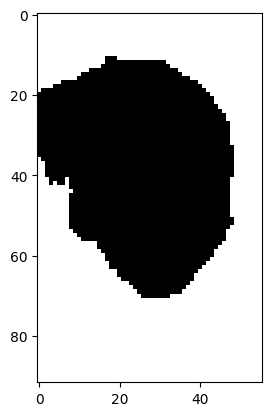

In [169]:
#with h5py.File(data_settings.data_filepath, 'r') as f:
    #data = np.array(f['data1']).T
print(data.shape)
#img = unmask(data[0, 0:108300], pMask).get_fdata().T
print(img.shape);print('\n\n')
print(img)
plt.imshow(img[25, :, :], cmap = plt.cm.binary)
plt.imshow(pMask.slicer[25:26].get_fdata()[0], cmap = plt.cm.binary)


In [187]:
# Dataset Reader Importing
#sys.path.append(f"{data_settings.main_folderpath}/Dataset Reader")
#from h1DMUDI import h1DMUDI

# Dataset Version Creation
data = h1DMUDI(data_settings)
#pX, pMask = data.get_patient(0)
#pX_train, pX_val, py_train, py_val = data.split_patient(0)
data.split(data_settings)
data.save()


---

# **VW-CVAE** *Model*

### *Voxel-Wise Conditional Variational AutoEncoder*

---

## *Model* **Architecture**

In [13]:
##############################################################################################
# --------------------------------------- Encoder Build --------------------------------------
##############################################################################################

# Encoder Model Class
class Encoder(nn.Module):

    # Constructor / Initialization Function
    def __init__(
        self,
        settings: argparse.ArgumentParser    # Model Settings & Parametrizations
        #num_labels: int = 5,                # Number of Labels contained in Dataset
        #num_channel: int = 64,              # Number of Output Channels for Encoder
        #num_layers: int = 3,                # Number of Main Convolutional Layers
        #latent_dim: int = 64                # Latent Space Dimensionality
    ):

        # Class Variable Logging
        super(Encoder, self).__init__()
        self.settings = settings

        # Encoder Downsampling Architecture Definition
        net = []; in_channel = 1 + settings.num_labels
        for i in reversed(range(settings.num_layers)):
            out_channel = int(settings.num_channel / (2 ** i))      # Current Main Layer's Output Channels
            #k = 2 * (i + 1)                                        # Kernel Size Value (6 is too high for Voxel-Wise CVAE)
            #print(f"{in_channel} -> {out_channel}")
            net.append(nn.Sequential(                               # Main Layer Block Repeatable Architecture
                nn.Conv1d(      in_channels = in_channel,
                                out_channels = out_channel,
                                kernel_size = 1, stride = 2, padding = 0),
                nn.LeakyReLU(   inplace = True)))
            in_channel = out_channel                                # Next Main Layer's Input Channels
        self.net = nn.Sequential(*net)
        
        # Mean and LogVariance Computation Linear Layers
        self.mean_layer = nn.Linear(    in_features = settings.num_channel,
                                        out_features = settings.latent_dim)
        self.logvar_layer = nn.Linear(  in_features = settings.num_channel,
                                        out_features = settings.latent_dim)

    # --------------------------------------------------------------------------------------------

    # Encoder Application Function
    def forward(
        self,
        X: np.ndarray or torch.Tensor,      # 1D Image Input
        y: np.ndarray or torch.Tensor       # Image Labels Input
    ):

        # Net Input Handling
        X = torch.Tensor(X).view(-1, 1, 1).to(self.settings.device)                             # Input Features | [batch_size, 1,              1]
        y = torch.Tensor(y).view(-1, self.settings.num_labels, 1).to(self.settings.device)      # Input Labels   | [batch_size, num_labels,     1]
        input = torch.cat((X, y), dim = 1)                                                      # Encoder Output | [batch_size, 1+num_channel,  1]
        
        # Forward Propagation in Encoder Architecture
        output = self.net(input)                                                                # Encoder Output | [batch_size, num_channel,    1]
        z_mean = self.mean_layer(output.view(-1, self.settings.num_channel))                    # Latent Mean    | [batch_size, latent_dim]
        z_logvar = self.logvar_layer(output.view(-1, self.settings.num_channel))                # Latent LogVar  | [batch_size, latent_dim]

        # Display Settings for Experimental Model Version
        if self.settings.model_version == 0:
            print(f"Encoder Input  | {list(input.shape)}")
            print(f"Encoder Output | {list(output.shape)}")
            print(f"Latent Mean    | {list(z_mean.shape)}")
            print(f"Latent LogVar  | {list(z_logvar.shape)}\n")
        return z_mean, z_logvar


In [16]:
##############################################################################################
# --------------------------------------- Decoder Build --------------------------------------
##############################################################################################

# Decoder Model Class
class Decoder(nn.Module):

    # Constructor / Initialization Function
    def __init__(
        self,
        settings: argparse.ArgumentParser    # Model Settings & Parametrizations
        #num_labels: int = 5,                # Number of Labels contained in Dataset
        #num_channel: int = 64,              # Number of Output Channels for Encoder
        #num_layers: int = 3,                # Number of Main Convolutional Layers
        #latent_dim: int = 64                # Latent Space Dimensionality
    ):

        # Class Variable Logging
        super(Decoder, self).__init__()
        self.settings = settings

        # Decoder Upsampling Architecture Definition
        net = []; in_channel =  settings.num_channel
        self.linear = nn.Linear(in_features = settings.latent_dim + settings.num_labels,
                                out_features = settings.num_channel)
        for i in range(settings.num_layers):
            out_channel = int(settings.num_channel / (2 ** (i + 1)))    # Current Main Layer's Output Channels
            if i == settings.num_layers - 1: out_channel = 1            # Last Layer's Single Voxel Output Channel
            #k = 2 * (i + 1)                                            # Kernel Size Value (6 is too high for Voxel-Wise CVAE)
            #print(f"{in_channel} -> {out_channel}")
            net.append(nn.Sequential(                                   # Main Layer Block Repeatable Architecture
                nn.ConvTranspose1d( in_channels = in_channel,
                                    out_channels = out_channel,
                                    kernel_size = 1, stride = 2, padding = 0),
                nn.LeakyReLU(       inplace = True)))
            in_channel = out_channel                                    # Next Main Layer's Input Channels
        net.append(nn.Sigmoid()); self.net = nn.Sequential(*net)
            
    # --------------------------------------------------------------------------------------------

    # Decoder Application Function
    def forward(
        self,
        z: np.ndarray or torch.Tensor,      # Latent Dimension Representation
        y: np.ndarray or torch.Tensor       # Image Labels Input
    ):

        # Net Input Handling
        z = torch.Tensor(z).to(self.settings.device)        # Latent Representation | [batch_size, latent_dim]
        y = torch.Tensor(y).to(self.settings.device)        # Input Labels          | [batch_size, num_labels]
        input = torch.cat((z, y), dim = 1)                  # Decoder Input         | [batch_size, latent_dim + num_labels]

        # Forward Propagation in Decoder Architecture
        output = self.linear(input).view(-1, self.settings.num_channel, 1)
        output = self.net(output).view(-1, 1)

        # Display Settings for Experimental Model Version
        if self.settings.model_version == 0:
            print(f"Decoder Input  | {list(input.shape)}")
            print(f"Decoder Output | {list(output.shape)}\n")
        return output


In [17]:
##############################################################################################
# ----------------------------------- Voxel-Wise CVAE Build ----------------------------------
##############################################################################################

# Decoder Model Class
class VWCVAE(nn.Module):

    # Constructor / Initialization Function
    def __init__(
        self,
        settings: argparse.ArgumentParser    # Model Settings & Parametrizations
    ):

        # Class Variable Logging
        super(VWCVAE, self).__init__()
        self.settings = settings
        self.encoder = Encoder(settings)      # Encoder Architecture Definition
        self.decoder = Decoder(settings)      # Decoder Architecture Definition
        
    # --------------------------------------------------------------------------------------------
    
    # Latent Dimension Reparametrization Gimmick Function
    def reparametrize(
        self,
        z_mean: torch.Tensor,           # Latent Dimension Mean
        z_logvar: torch.Tensor          # Latent Dimension Logarithmic Variance
    ):

        eps = torch.randn(  z_mean.size(0),                             # Epsilon Sampling from
                            z_mean.size(1)).to(self.settings.device)    # Standard Normal Distribution
        z = z_mean + (eps * torch.exp(z_logvar / 2.0))                  # Latent Dimension Representation
        return z

    # --------------------------------------------------------------------------------------------

    # Encoder Application Function
    def forward(
        self,
        X: np.ndarray or torch.Tensor,      # 1D Image Input
        y: np.ndarray or torch.Tensor       # Image Labels Input
    ):

        # Forward Propagation in Encoder Architecture
        X = torch.Tensor(X)                             # Input Features        | [batch_size, 1]
        y = torch.Tensor(y).to(self.settings.device)    # Input Labels          | [batch_size, num_labels]
        z_mean, z_logvar = self.encoder(X, y)           # Encoder Output        | [batch_size, latent_dim]
        z = self.reparametrize(z_mean, z_logvar)        # Latent Representation | [batch_size, latent_dim]
        output = self.decoder(z, y)                     # Decoder Output        | [batch_size, 1]

        # Display Settings for Experimental Model Version
        if self.settings.model_version == 0:
            print(f"Model Features Input  | {list(X.shape)}")
            print(f"Model Labels Input    | {list(y.shape)}")
            print(f"Latent Representation | {list(z.shape)}")
            print(f"Model Output          | {list(output.shape)}")
        return output

In [18]:
# Data Initialization Simulation
X = torch.rand((5000, 1))
y = torch.ones((5000, 5))
z = torch.rand((5000, 128))

"""
# Encoder Initialization & Usage Example
enc = Encoder(model_settings)
z_mean, z_logvar = enc(X, y)
#summary(enc.net, (1 + model_settings.num_labels, 1))
"""

"""
# Decoder Initialization & Usage Example
dec = Decoder(model_settings)
output = dec(z, y)
#summary(dec.net, (model_settings.num_channel, 1))
"""

# Full Voxel-Wise CVAE Initialization & Usage Example
model = VWCVAE(model_settings)
output = model(X, y)

Encoder Input  | [5000, 6, 1]
Encoder Output | [5000, 64, 1]
Latent Mean    | [5000, 128]
Latent LogVar  | [5000, 128]

Decoder Input  | [5000, 133]
Decoder Output | [5000, 1]

Model Features Input  | [5000, 1]
Model Labels Input    | [5000, 5]
Latent Representation | [5000, 128]
Model Output          | [5000, 1]


## **Running** *Script*

In [ ]:
# Voxel-Wise CVAE Model Training, Validation & Testing Script Class
class LitVWCVAE(pl.LightningModule):

    ##############################################################################################
    # ----------------------------------- Model & Dataset Setup ----------------------------------
    ##############################################################################################

    # Constructor / Initialization Function
    def __init__(
        self,
        settings: argparse.ArgumentParser,              # Model Settings & Parametrizations
    ):

        # Class Variable Logging
        super().__init__()
        self.settings = settings
        self.lr_decay_epochs = [80, 140]                # Epochs for Learning Rate Decay

        # Model Initialization
        self.model = VWCVAE(                self.settings)
        self.optimizer = torch.optim.Adam(  self.model.parameters(),
                                            lr = self.settings.base_lr,
                                            weight_decay = self.settings.weight_decay, )
        self.recon_criterion = nn.MSELoss(); self.past_epochs = 0

        # Existing Model Checkpoint Loading
        self.model_filepath = Path(f"{self.settings.save_folderpath}/V{self.settings.model_version}/All4One (V{self.settings.model_version}).pth")
        if self.settings.model_version != 0 and self.model_filepath.exists():

            # Checkpoint Fixing (due to the use of nn.DataParallel)
            print(f"DOWNLOADING All4One 2D VAE (Version {self.settings.model_version})")
            checkpoint = torch.load(self.model_filepath); self.checkpoint_fix = dict()
            for sd, sd_value in checkpoint.items():
                if sd == 'ModelSD' or sd == 'OptimizerSD':
                    self.checkpoint_fix[sd] = OrderedDict()
                    for key, value in checkpoint[sd].items():
                        if key[0:7] == 'module.':
                            self.checkpoint_fix[sd][key[7:]] = value
                        else: self.checkpoint_fix[sd][key] = value
                else: self.checkpoint_fix[sd] = sd_value
            
            # Application of Checkpoint's State Dictionary
            self.model.load_state_dict(self.checkpoint_fix['ModelSD'])
            self.optimizer.load_state_dict(self.checkpoint_fix['OptimizerSD'])
            self.past_epochs = self.checkpoint_fix['Training Epochs']
            torch.set_rng_state(self.checkpoint_fix['RNG State'])
            del checkpoint
        self.lr_schedule = torch.optim.lr_scheduler.ExponentialLR(  self.optimizer,     # Learning Rate Decay
                                                    gamma = self.settings.lr_decay)     # in Chosen Epochs
        self.model = nn.DataParallel(self.model.to(self.settings.device))

    # Optimizer Initialization Function
    def configure_optimizers(self): return super().configure_optimizers()

    # Foward Functionality
    def forward(self, X): return self.model(X)

    # --------------------------------------------------------------------------------------------
    
    # Train Set DataLoader Download
    def train_dataloader(self):
        TrainTrainLoader = h1DMUDI.loader(  Path(f"{self.settings.data_folderpath}"),
                                            dim = 2, version = self.settings.data_version,
                                            set_ = 'Test', mode_ = 'Train')
                                            #set_ = 'Train', mode_ = 'Train')
        self.train_batches = len(TrainTrainLoader)
        return TrainTrainLoader
    
    # Validation Set DataLoader Download
    def val_dataloader(self):
        TrainValLoader = h1DMUDI.loader(Path(f"{self.settings.data_folderpath}"),
                                        dim = 2, version = self.settings.data_version,
                                        set_ = 'Test', mode_ = 'Train')
                                        #set_ = 'Train', mode_ = 'Val')
        self.val_batches = len(TrainValLoader)
        return TrainValLoader

    # Test Set DataLoader Download
    def test_dataloader(self):
        TestValLoader = h1DMUDI.loader( Path(f"{self.settings.data_folderpath}"),
                                        dim = 2, version = self.settings.data_version,
                                        set_ = 'Test', mode_ = 'Val')
        self.test_batches = len(TestValLoader)
        return TestValLoader

    ##############################################################################################
    # ------------------------------------- Training Script --------------------------------------
    ##############################################################################################

    # Functionality called upon the Start of Training
    def on_train_start(self):
        
        # Model Training Mode Setup
        self.model.train()
        self.automatic_optimization = False

        # TensorBoard Logger Initialization
        self.train_logger = TensorBoardLogger(f'{self.settings.save_folderpath}/V{self.settings.model_version}', 'Training Performance')

    # Functionality called upon the Start of Training Epoch
    def on_train_epoch_start(self):
        self.train_loss = 0
        self.train_kl_loss = 0
        self.train_recon_loss = 0

    # --------------------------------------------------------------------------------------------

    # Training Step / Batch Loop 
    def training_step(self, batch, batch_idx):

        # Data Handling
        X_batch, ygt_batch = batch
        X_batch = X_batch.type(torch.float).to(self.settings.device)
        #ygt_batch = ygt_batch.type(torch.float).to(self.settings.device)

        # Forward Propagation & Loss Computation

---

# **clNN** *Model*

---

## *Model* **Architecture**

In [25]:
##############################################################################################
# --------------------------------------- Encoder Class --------------------------------------
##############################################################################################

# clNN Encoder Model Class
class Encoder(nn.Module):

    # Constructor / Initialization Function
    def __init__(
        self,
        settings: argparse.ArgumentParser,      # Model Settings & Parametrizations
        #in_params: int = 500,                  # Number of Input Parameter Settings
        #out_params: int = 1344,                # Number of Output Parameter Settings
        #var_hidden: int = 128,                 # Deviance / Expansion of Hidden Layers
        profiler = None                         # Pytorch Lightning Profiler
    ) -> None:

        # Class Variable & Buffer Logging
        super(Encoder, self).__init__()
        self.profiler = profiler or pl.profilers.PassThroughProfiler()
        self.settings = settings
        self.register_buffer('temp', torch.tensor(self.settings.max_temp))
        self.register_buffer('max_temp', torch.tensor(self.settings.max_temp))
        self.register_buffer('min_temp', torch.tensor(self.settings.min_temp))
        self.register_buffer('reg_eps', torch.tensor(self.settings.reg_eps))
        self.register_buffer('min_temp', torch.tensor(self.settings.min_temp))

        # Random Weight Initialization
        logits = nn.init.xavier_normal_(torch.empty(self.settings.in_params,
                                                    self.settings.latent_dim))
        self.logits = nn.Parameter(logits, requires_grad = True)
    
    # --------------------------------------------------------------------------------------------

    # clNN Encoder Application Function
    def forward(
        self,
        X: torch.Tensor         # 1D Voxel Array Input
    ) -> torch.Tensor:
        
        with self.profiler.profile('Encoder'):
            selection: torch.Tensor = None
            
            # Training Mode
            if self.training:
                uniform = torch.rand(self.logits.size()).to(X.device)
                gumbel = -torch.log(-torch.log(uniform))
                logits_noise = (self.logits + gumbel) / self.temp
                sample = F.softmax(logits_noise, dim = 1); selection = sample
            
            # Validation Mode
            else:
                logits_argmax = torch.argmax(self.logits, len(self.logits.size()) - 1)
                logits_discrete = F.one_hot(logits_argmax, num_classes = self.logits.size()[1])
                selection = logits_discrete
            
        return torch.matmul(X, torch.transpose(selection.float(), 0, 1))

    # --------------------------------------------------------------------------------------------

    # Temperature Update Functionality
    def update_temp(
        self,
        current_epoch: int,
        max_epochs: int
    ) -> torch.Tensor:
        
        self.temp = self.max_temp * torch.pow(
            (self.min_temp / self.max_temp), (current_epoch / max_epochs))
        return self.temp

    # Logit Mean Computation Functionality
    def calc_mean_max(self) -> torch.Tensor:

        logits_softmax = F.softmax(self.logits, dim=1)
        logits_max = torch.max(logits_softmax, 1).values
        return torch.mean(logits_max)

    # --------------------------------------------------------------------------------------------

    # Index Obtaining Functionality
    def get_indexes(self):

        val = torch.argmax(self.logits, 1)
        return val

    # Regularization Functionality
    def regularization(self) -> float:
        
        selection = torch.clamp(F.softmax(self.logits, dim = 1), self.reg_eps, 1)
        return torch.sum(F.relu(torch.norm(selection, 1, dim = 0) - self.reg_threshold))


In [30]:
##############################################################################################
# --------------------------------------- Decoder Class --------------------------------------
##############################################################################################

# clNN Decoder Model Class
class Decoder(nn.Module):

    # Constructor / Initialization Function
    def __init__(
        self,
        settings: argparse.ArgumentParser,      # Model Settings & Parametrizations
        #in_params: int = 500,                  # Number of Input Parameter Settings
        #out_params: int = 1344,                # Number of Output Parameter Settings
        #var_hidden: int = 128,                 # Deviance / Expansion of Hidden Layers
        profiler = None                         # Pytorch Lightning Profiler
    ) -> None:

        # Class Variable Logging
        super(Decoder, self).__init__()
        self.settings = settings
        
        # Decoder Layer Size & Dimensionality
        idx = np.arange(2 + self.settings.num_hidden)
        data_idx = np.array([idx[0], idx[-1]])
        data = np.array([self.settings.latent_dim, self.settings.out_params])
        layer_dim = np.interp(idx, data_idx, data).astype(int)

        # Decoder Architecture Construction
        decoder = OrderedDict()
        for i in range(1, len(layer_dim)):
            if i == len(layer_dim) - 1:
                decoder[f'Linear Layer #{i - 1}'] = nn.Linear(layer_dim[i - 1], layer_dim[i])
            else:
                decoder[f'Linear Layer #{i - 1}'] = nn.Linear(layer_dim[i - 1], layer_dim[i])
                decoder[f'Leaky ReLU #{i - 1}'] = nn.LeakyReLU(self.settings.neg_slope)
        self.decoder = nn.Sequential(decoder)

    # --------------------------------------------------------------------------------------------

    # clNN Encoder Application Function
    def forward(
        self,
        X: torch.Tensor         # 1D Voxel Array Input
    ) -> torch.Tensor:
        
        return self.decoder(X)


In [31]:
# Data Initialization Example
X_real = torch.rand((100, 500))
y = torch.rand((100, 5))

# Model Initialization & Usage Example
encoder = Encoder(model_settings)
decoder = Decoder(model_settings)
h = encoder(X_real); X_fake = decoder(h)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (100x500 and 128x500)

## **Running** *Script*

---

# **fcNN** *Model*

### *Previously Used Fully Connected Neural Network*

---

## **Personal** *Iteration*

### *Model* **Architecture**

In [133]:
# Linear Fully Connected Neural Network Model Class
class fcNN(nn.Module):

    # Constructor / Initialization Function
    def __init__(
        self,
        in_params: int = 500,                   # Number of Input Parameter Settings
        out_params: int = 1344,                 # Number of Output Parameter Settings
        num_hidden: int = 2                     # Number of NN Hidden Layers
    ):

        # Class Variable Logging
        super(fcNN, self).__init__()
        self.in_params = in_params; self.out_params = out_params; self.num_hidden = num_hidden
        assert(self.out_params > self.in_params
               ),"ERROR: Neural Network wrongly built!"
        net = []; num_neuron = self.in_params

        # Neural Network Architecture Definition
        num_fc = int(np.floor((self.out_params - self.in_params) / (self.num_hidden + 1)))
        for i in range(self.num_hidden + 1):
            if i == self.num_hidden: num_fc += 1
            net.append( nn.Sequential(
                            nn.Linear(num_neuron, num_neuron + num_fc),
                            nn.LeakyReLU(inplace = True)))
            num_neuron += num_fc
        assert(num_neuron == self.out_params), "ERROR: Neural Network wrongly built!"
        self.net = nn.Sequential(*net)
    
    # --------------------------------------------------------------------------------------------

    # Neural Network Application Function
    def forward(
        self,
        X: np.ndarray or torch.Tensor,      # 1D Image Input
    ):
    
        # Forward Propagation in Neural Network Architecture
        #X = torch.Tensor(X).to(self.settings.device)
        return self.net(X)

In [134]:
# Linear Fully Connected Neural Network Usage Example
X = torch.rand((108300, 500))
model = fcNN()
out = model(X)
print(out.shape)

torch.Size([108300, 1344])


### **Running** *Script*

In [26]:
# fcNN Model Training, Validation & Testing Script Class
class LitfcNN(pl.LightningModule):

    ##############################################################################################
    # ---------------------------------------- Model Setup ---------------------------------------
    ##############################################################################################

    # Constructor / Initialization Function
    def __init__(
        self,
        settings: argparse.ArgumentParser,              # Model Settings & Parametrizations
    ):

        # Class Variable Logging
        super().__init__()
        self.settings = settings
        self.lr_decay_epochs = [80, 140]                # Epochs for Learning Rate Decay

        # Model Initialization
        self.model = fcNN(                  in_params = self.settings.in_params,
                                            out_params = self.settings.out_params,
                                            num_hidden = self.settings.num_hidden)
        self.optimizer = torch.optim.Adam(  self.model.parameters(),
                                            lr = self.settings.base_lr,
                                            weight_decay = self.settings.weight_decay)
        self.criterion = nn.MSELoss(); self.recon_criterion = nn.MSELoss()
        self.past_epochs = 0

        # Existing Model Checkpoint Loading
        self.model_filepath = Path(f"{self.settings.save_folderpath}/V{self.settings.model_version}/fcNN (V{self.settings.model_version}).pth")
        if self.settings.model_version != 0 and self.model_filepath.exists():

            # Checkpoint Fixing (due to the use of nn.DataParallel)
            print(f"DOWNLOADING Fully Connected Neural Network (Version {self.settings.model_version})")
            checkpoint = torch.load(self.model_filepath); self.checkpoint_fix = dict()
            for sd, sd_value in checkpoint.items():
                if sd == 'ModelSD' or sd == 'OptimizerSD':
                    self.checkpoint_fix[sd] = OrderedDict()
                    for key, value in checkpoint[sd].items():
                        if key[0:7] == 'module.':
                            self.checkpoint_fix[sd][key[7:]] = value
                        else: self.checkpoint_fix[sd][key] = value
                else: self.checkpoint_fix[sd] = sd_value
            
            # Application of Checkpoint's State Dictionary
            self.model.load_state_dict(self.checkpoint_fix['ModelSD'])
            self.optimizer.load_state_dict(self.checkpoint_fix['OptimizerSD'])
            self.past_epochs = self.checkpoint_fix['Training Epochs']
            torch.set_rng_state(self.checkpoint_fix['RNG State'])
            del checkpoint
        self.lr_schedule = torch.optim.lr_scheduler.ExponentialLR(  self.optimizer,     # Learning Rate Decay
                                                    gamma = self.settings.lr_decay)     # in Chosen Epochs
        self.model = nn.DataParallel(self.model.to(self.settings.device))
        
    # Optimizer Initialization Function
    def configure_optimizers(self): return super().configure_optimizers()

    # Foward Functionality
    def forward(self, X): return self.model(X)

    ##############################################################################################
    # -------------------------------------- Dataset Setup ---------------------------------------
    ##############################################################################################
    
    # Train Set DataLoader Download
    def train_dataloader(self):
        TrainLoader = h1DMUDI.loader(  Path(f"{self.settings.data_folderpath}"),
                                            version = self.settings.data_version,
                                            mode_ = 'Train')
        self.train_batches = len(TrainLoader)
        return TrainLoader

    # Test Set DataLoader Download
    def test_dataloader(self):
        TestLoader = h1DMUDI.loader( Path(f"{self.settings.data_folderpath}"),
                                        version = self.settings.data_version,
                                        mode_ = 'Test')
        self.test_batches = len(TestLoader)
        return TestLoader

    # --------------------------------------------------------------------------------------------

    # Patient Image Reconstruction
    def reconstruct(
        self,
        mode: str,
        #sel_patient: int = 0,           # Selected Example Patient
        sel_params: int = 0,            # Selected Parameter Setting Index
        sel_slice: int = 25             # Selected Slice
    ):
        
        # Dataset & Real 3D Image Access
        num_epochs = self.past_epochs + self.current_epoch
        if mode == 'Train':
            if self.current_epoch == 0:
                self.data = h1DMUDI.load(self.settings.data_folderpath, self.settings.data_version)
                self.pX_train, self.pMask_train = self.data.get_patient(0)
            pX = self.pX_train; pMask = self.pMask_train; sel_patient = 0
        elif mode == 'Test':
            if self.current_epoch == 0:
                self.data = h1DMUDI.load(self.settings.data_folderpath, self.settings.data_version)
                self.pX_test, self.pMask_test = self.data.get_patient(4)
            pX = self.pX_test; pMask = self.pMask_test; sel_patient = 4

        # --------------------------------------------------------------------------------------------

        # Fake 3D Image Generation
        pX_real = unmask(pX, pMask); pX_real = pX_real.get_fdata().T
        pX_fake = self.model(torch.Tensor(np.array(pX)[self.data.idx_train.astype(int), :]).T)
        pX_fake = unmask(pX_fake.detach().numpy().T, pMask); pX_fake = pX_fake.get_fdata().T
        assert(np.all(pX_real.shape == pX_fake.shape)), "ERROR: Unmasking went Wrong!"
        loss = self.recon_criterion(torch.Tensor(pX_fake), torch.Tensor(pX_real))

        # --------------------------------------------------------------------------------------------

        # Original Training Example Image Subplot
        figure = plt.figure(num_epochs, figsize = (60, 60))
        patient_id = self.data.patient_info['Patient'].iloc[sel_patient]
        plt.tight_layout(); plt.title(f'Epoch #{num_epochs} | Patient #{patient_id}'
                        + f' | Parameter Combo #{sel_params} | Slice #{sel_slice}')
        plt.subplot(2, 1, 1, title = 'Original Image')
        plt.xticks([]); plt.yticks([]); plt.grid(False); plt.tight_layout()
        plt.imshow(pX_real[sel_params, sel_slice, :, :], cmap = plt.cm.binary)

        # Reconstructed Training Example Image Subplot
        plt.subplot(2, 1, 2, title = 'Reconstructed Image')
        plt.xticks([]); plt.yticks([]); plt.grid(False)
        plt.imshow(pX_fake[sel_params, sel_slice, :, :], cmap = plt.cm.binary)
        return figure, loss
    
    ##############################################################################################
    # ------------------------------------- Training Script --------------------------------------
    ##############################################################################################

    # Functionality called upon the Start of Training
    def on_train_start(self):
        
        # Model Training Mode Setup
        self.model.train()
        self.automatic_optimization = False

        # TensorBoard Logger Initialization
        self.train_logger = TensorBoardLogger(f'{self.settings.save_folderpath}/V{self.settings.model_version}', 'Training Performance')

    # Functionality called upon the Start of Training Epoch
    def on_train_epoch_start(self): self.train_loss = 0

    # --------------------------------------------------------------------------------------------

    # Training Step / Batch Loop 
    def training_step(self, batch, batch_idx):

        # Data Handling
        X_train_batch, X_val_batch = batch
        X_train_batch = X_train_batch.type(torch.float).to(self.settings.device)
        X_batch = torch.cat((X_train_batch, X_val_batch), 1).type(torch.float).to(self.settings.device)

        # Forward Propagation & Loss Computation
        X_fake_batch = self.model(X_train_batch)
        loss = self.criterion(X_fake_batch, X_batch)

        # Backwards Propagation
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        del X_batch, X_train_batch, X_val_batch, X_fake_batch
        return loss

    # Functionality called upon the End of a Batch Training Step
    def on_train_batch_end(self, loss, batch, batch_idx): self.train_loss = self.train_loss + loss['loss'].item()

    # --------------------------------------------------------------------------------------------

    # Functionality called upon the End of a Training Epoch
    def on_train_epoch_end(self):

        # Learning Rate Decay
        if (self.trainer.current_epoch + 1) in self.lr_decay_epochs:
            self.lr_schedule.step()

        # Epoch Update for Losses & Reconstructed Images
        num_epochs = self.past_epochs + self.current_epoch
        self.train_loss = self.train_loss / self.train_batches
        train_plot, train_recon_loss = self.reconstruct(mode = 'Train',
                                                        sel_params = 0,
                                                        sel_slice = 25)
        
        # TensorBoard Logger Model Visualizer, Update for Scalar Values & Image Visualizer
        if num_epochs == 0: self.train_logger.experiment.add_graph(self.model, torch.rand(1, self.settings.in_params))
        self.train_logger.experiment.add_scalar("Loss", self.train_loss, num_epochs)
        self.train_logger.experiment.add_scalar("Reconstruction Loss", train_recon_loss, num_epochs)
        self.train_logger.experiment.add_figure(f'Image Reconstruction', train_plot, num_epochs)

        # Model Checkpoint Saving
        torch.save({'ModelSD': self.model.state_dict(),
                    'OptimizerSD': self.optimizer.state_dict(),
                    'Training Epochs': num_epochs,
                    'RNG State': torch.get_rng_state()},
                    self.model_filepath)

    ##############################################################################################
    # -------------------------------------- Testing Script --------------------------------------
    ##############################################################################################

    # Functionality called upon the Start of Training
    def on_test_start(self):

        # TensorBoard Logger Initialization
        self.model.eval()
        self.test_logger = TensorBoardLogger(f'{self.settings.save_folderpath}/V{self.settings.model_version}', 'Testing Performance')
    
    # Functionality called upon the Start of Training Epoch
    def on_test_epoch_start(self): self.test_loss = 0

    # --------------------------------------------------------------------------------------------

    # Test Step / Batch Loop 
    def test_step(self, batch, batch_idx):

        # Data Handling
        X_train_batch, X_val_batch = batch
        X_train_batch = X_train_batch.type(torch.float).to(self.settings.device)
        X_batch = torch.cat((X_train_batch, X_val_batch), 1).type(torch.float).to(self.settings.device)

        # Forward Propagation & Loss Computation
        X_fake_batch = self.model(X_train_batch)
        loss = self.criterion(X_fake_batch, X_batch)
        del X_batch, X_train_batch, X_val_batch, X_fake_batch
        return loss

    # Functionality called upon the End of a Batch Test Step
    def on_test_batch_end(self, loss, batch, batch_idx): self.test_loss = self.test_loss + loss['loss'].item()

    # --------------------------------------------------------------------------------------------

    # Functionality called upon the End of a Training Epoch
    def on_test_epoch_end(self):

        # Epoch Update for Losses & Reconstructed Images
        num_epochs = self.past_epochs + self.current_epoch
        self.test_loss = self.test_loss / self.test_batches
        test_plot, test_recon_loss = self.reconstruct(  mode = 'Test',
                                                        sel_params = 0,
                                                        sel_slice = 25)
        
        # TensorBoard Logger Update for Scalar Values & Image Visualizer
        self.test_logger.experiment.add_scalar("Loss", self.test_loss, num_epochs)
        self.test_logger.experiment.add_scalar("Reconstruction Loss", test_recon_loss, num_epochs)
        self.test_logger.experiment.add_figure(f'Image Reconstruction', test_plot, num_epochs)
        

In [ ]:
##############################################################################################
# ----------------------------------------- Dataset ------------------------------------------
##############################################################################################

# Dataset Access
sys.path.append(f"{data_settings.main_folderpath}/Dataset Reader")
from h1DMUDI import h1DMUDI

"""
# Dataset Version Creation
data = h1DMUDI(data_settings)
data.split(data_settings)
data.save()
"""

##############################################################################################
# --------------------------------------- fcNN Model -----------------------------------------
##############################################################################################

# Full fcNN All4One 2D VAE Model Class Importing
sys.path.append(model_settings.model_folderpath)
from fcNN import fcNN
sys.path.append(model_settings.script_folderpath)
from LitfcNN import LitfcNN

# --------------------------------------------------------------------------------------------

# Model Initialization & Training
fcNN = LitfcNN(model_settings)
fcNN_trainer = pl.Trainer(      max_epochs = 3,
                                #max_epochs = model_settings.num_epochs,
                                devices = 1 if torch.cuda.is_available() else None,
                                enable_progress_bar = True,
                                callbacks = [pl.callbacks.TQDMProgressBar(refresh_rate = 1)])
#fcNN_trainer.test(fcNN)
%load_ext tensorboard

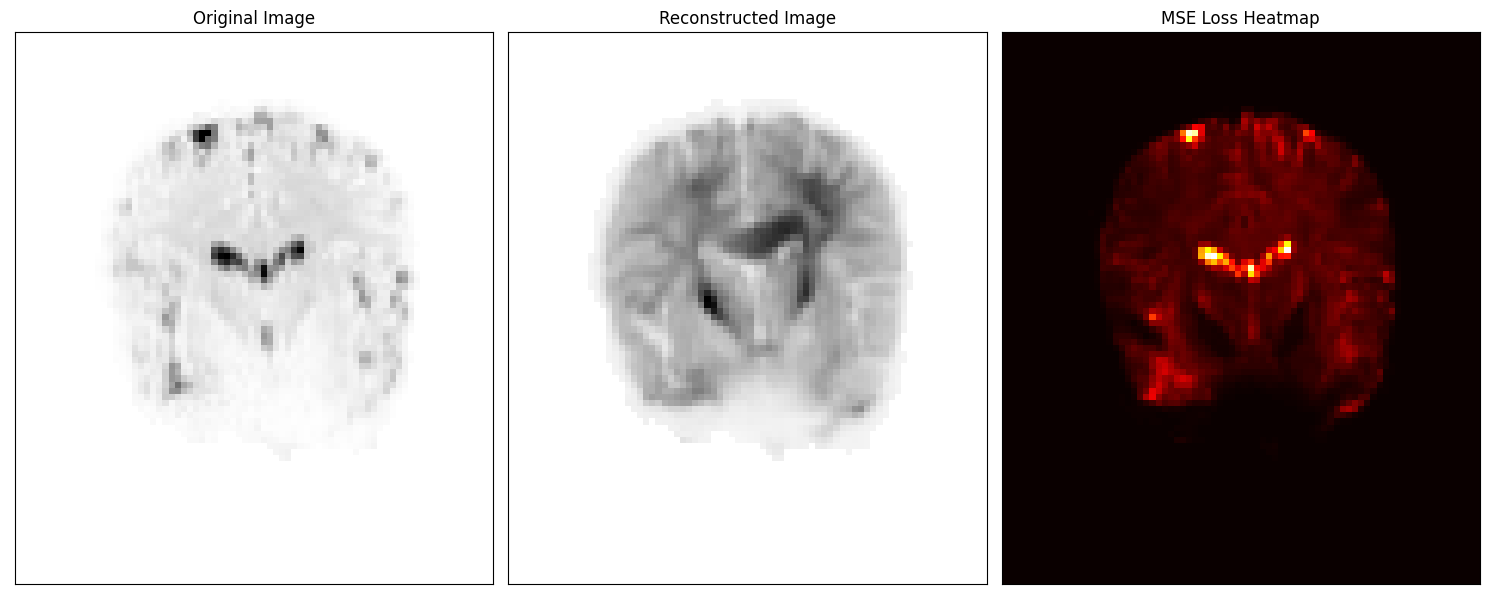

In [137]:
##############################################################################################
# ------------------------------------ Image Visualization -----------------------------------
##############################################################################################

# 3D Interactive Plotting Function
def plot(
    num_param: int = 0,
    num_slice: int = 0
):

    # Original Training Example Image Subplot
    figure = plt.figure(figsize = (15, 15))
    patient_id = data.patient_info['Patient'].iloc[4]
    plt.tight_layout(); plt.title(f'Test Patient #{patient_id} | Parameters #{num_param} | Slice #{num_slice}')
    plt.subplot(1, 3, 1, title = 'Original Image')
    plt.xticks([]); plt.yticks([]); plt.grid(False); plt.tight_layout()
    plt.imshow(X_real[num_param, num_slice, :, :], cmap = plt.cm.binary)

    # Reconstructed Training Example Image & MSE Subplot
    plt.subplot(1, 3, 2, title = 'Reconstructed Image')
    plt.xticks([]); plt.yticks([]); plt.grid(False)
    plt.imshow(X_fake[num_param, num_slice, :, :], cmap = plt.cm.binary)

    # MSE Loss Heatmap Plotting
    plt.subplot(1, 3, 3, title = 'MSE Loss Heatmap')
    plt.xticks([]); plt.yticks([]); plt.grid(False)
    plt.imshow(heatmap[0, num_slice, :, :], cmap = 'hot')

# ----------------------------------------------------------------------------------------------------------------------------

# Test Patient Image Reconstruction
try: data
except NameError:

    # Original Image Access & Fake Image Generation
    data = h1DMUDI.load(model_settings.data_folderpath, model_settings.data_version)
    X_real, X_mask = data.get_patient(4)
    X_fake = fcNN.model(torch.Tensor(np.array(X_real)[data.idx_train.astype(int), :]).T)

    # MSE Loss Heatmap Generation
    heatmap = np.empty((1, X_real.shape[1]))
    for p in range(X_real.shape[1]):
        heatmap[0, p] = fcNN.criterion(X_fake.T[:, p], torch.Tensor(np.array(X_real.iloc[:, p])))

    # Original & Fake Image Unmasking
    X_real = unmask(X_real, X_mask); X_real = X_real.get_fdata().T
    X_fake = unmask(X_fake.detach().numpy().T, X_mask); X_fake = X_fake.get_fdata().T
    heatmap = unmask(heatmap, X_mask); heatmap = heatmap.get_fdata().T
    assert(np.all(X_real.shape == X_fake.shape)), "ERROR: Unmasking went Wrong!"

# Parameter + Slice Slider Interactive Construction
param_slider = IntSlider(value = 0, min = 0, max = X_real.shape[0] - 1, description = 'Parameter', continuous_update = False)
slice_slider = IntSlider(value = 0, min = 0, max = X_real.shape[1] - 1, description = 'Slice', continuous_update = False)
interactive(plot, num_param = param_slider, num_slice = slice_slider)
plot(500, 30)

# Original & Fake Image Saving
#img_real = nibabel.Nifti1Image(X_real.T, affine = np.eye(4)); img_real.header.get_xyzt_units()
#img_fake = nibabel.Nifti1Image(X_fake.T, affine = np.eye(4)); img_fake.header.get_xyzt_units()
#img_real.to_filename(Path(f"{model_settings.save_folderpath}/V{model_settings.model_version}/Test Patient Image (fcNN V{model_settings.model_version}).nii.gz"))
#img_fake.to_filename(Path(f"{model_settings.save_folderpath}/V{model_settings.model_version}/Test Patient Recon (fcNN V{model_settings.model_version}).nii.gz"))
#nibabel.save(img_real, Path(f"{model_settings.save_folderpath}/V{model_settings.model_version}/Test Patient Image (fcNN V{model_settings.model_version}).nii.gz"))
#nibabel.save(img_fake, Path(f"{model_settings.save_folderpath}/V{model_settings.model_version}/Test Patient Recon (fcNN V{model_settings.model_version}).nii.gz"))

## **Chantal's** *Iteration*

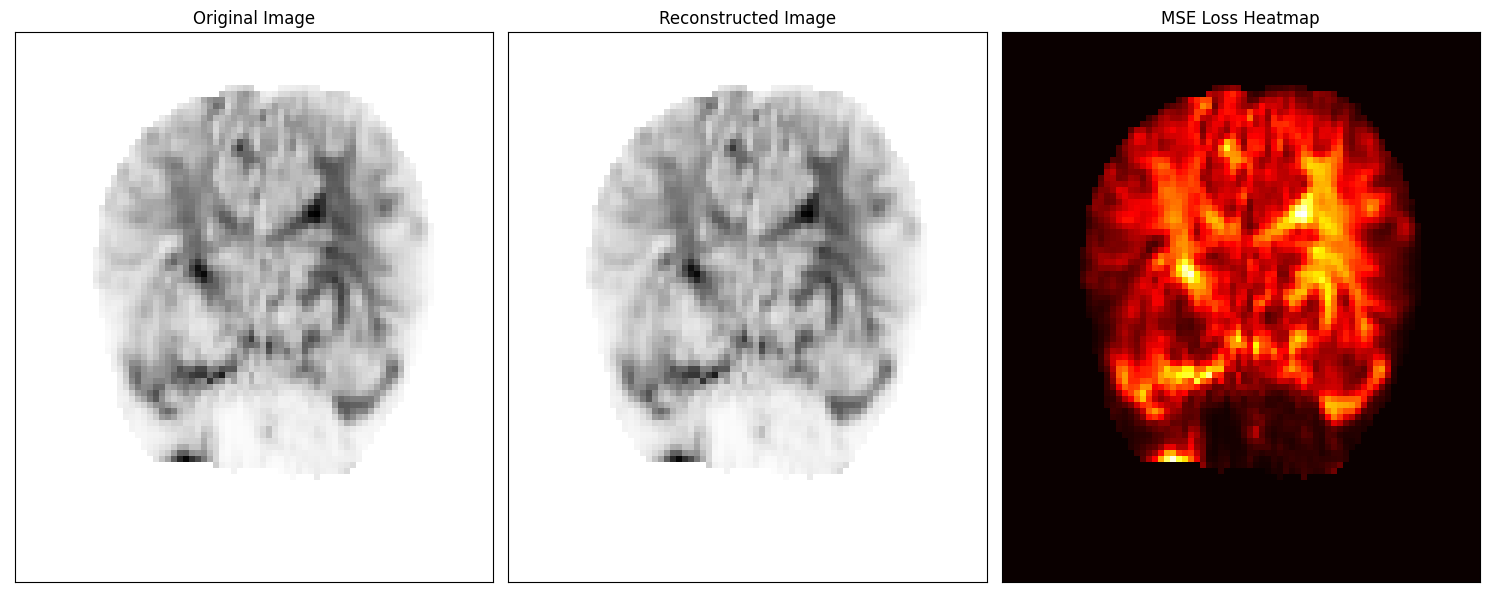

In [211]:
#############################################################################################
# ------------------------------------ Image Visualization -----------------------------------
##############################################################################################

# 3D Interactive Plotting Function
def plot(
    num_param: int = 0,
    num_slice: int = 0
):

    # Original Training Example Image Subplot
    figure = plt.figure(figsize = (15, 15))
    #patient_id = data.patient_info['Patient'].iloc[4]
    plt.tight_layout(); plt.title(f'Test Patient #{14} | Parameters #{num_param} | Slice #{num_slice}')
    plt.subplot(1, 3, 1, title = 'Original Image')
    plt.xticks([]); plt.yticks([]); plt.grid(False); plt.tight_layout()
    plt.imshow(X_real[num_param, num_slice, :, :], cmap = plt.cm.binary)

    # Reconstructed Training Example Image & MSE Subplot
    plt.subplot(1, 3, 2, title = 'Reconstructed Image')
    plt.xticks([]); plt.yticks([]); plt.grid(False)
    plt.imshow(X_fake[num_param, num_slice, :, :], cmap = plt.cm.binary)

    # MSE Loss Heatmap Plotting
    plt.subplot(1, 3, 3, title = 'MSE Loss Heatmap')
    plt.xticks([]); plt.yticks([]); plt.grid(False)
    plt.imshow(heatmap[num_param, num_slice, :, :], cmap = 'hot')

# ----------------------------------------------------------------------------------------------------------------------------

# Test Patient's Original & Fake Image Access
try: X_real
except NameError:
    #X_real = nib.load(f"{model_settings.save_folderpath}/V{model_settings.model_version}/Test Set Original.nii.gz").get_fdata().T
    X_real = np.real(nib.load(f"{model_settings.save_folderpath}/V{model_settings.model_version}/Test Set Original.nii.gz").dataobj).T
    X_fake = np.real(nib.load(f"{model_settings.save_folderpath}/V{model_settings.model_version}/Test Set Reconstruction.nii.gz").dataobj).T
    heatmap = np.real(nib.load(f"{model_settings.save_folderpath}/V{model_settings.model_version}/Test Set MSE Heatmap.nii.gz").dataobj).T

# Parameter + Slice Slider Interactive Construction
param_slider = IntSlider(value = 0, min = 0, max = X_real.shape[0] - 1, description = 'Parameter', continuous_update = False)
slice_slider = IntSlider(value = 0, min = 0, max = X_real.shape[1] - 1, description = 'Slice', continuous_update = False)
interactive(plot, num_param = param_slider, num_slice = slice_slider)
plot(800, 25)

---

# **cglVNN** *Model*

### *Conditional Generative Linear Voxel Neural Network*

---

## *Model* **Architecture**

In [62]:
# Conditional Linear Neural Network Model Class
class clNN(nn.Module):

    # Constructor / Initialization Function
    def __init__(
        self,
        num_labels: int = 5,                    # Number of Input Parameter Settings
        num_hidden: int = 2,                    # Number of NN Hidden Layers
        var_hidden: int = 128                   # Deviance / Expansion of Hidden Layers
    ):

        # Class Variable Logging
        super(clNN, self).__init__()
        self.num_labels = num_labels
        self.num_hidden = num_hidden
        self.var_hidden = var_hidden
        var_neuron = int(np.floor(self.var_hidden / self.num_hidden))

        # Neural Network Architecture Definition
        net = []; in_neuron = 1 + self.num_labels; out_neuron = var_neuron
        for i in range(1, (2 * self.num_hidden) + 1):
            if i == self.num_hidden: var_neuron = -var_neuron
            elif i == 2 * self.num_hidden: out_neuron = 1
            #print(f"{in_neuron} -> {out_neuron}")
            net.append( nn.Sequential(
                            nn.Linear(in_neuron, out_neuron),
                            nn.LeakyReLU(inplace = True)))
            in_neuron = out_neuron; out_neuron = out_neuron + var_neuron
        self.net = nn.Sequential(*net)
    
    # --------------------------------------------------------------------------------------------

    # Neural Network Application Function
    def forward(
        self,
        X: np.ndarray or torch.Tensor,      # 1D Voxel Input
        y: np.ndarray or torch.Tensor,      # 1D Image Label Input
    ):
    
        # Forward Propagation in Neural Network Architecture
        X = torch.Tensor(X)#.to(self.settings.device)
        y = torch.Tensor(y)#.to(self.settings.device)
        return self.net(torch.cat([X, y], dim = 1))

In [138]:
# Conditional Generative Linear Voxel Net Model Class
class cglVNN(nn.Module):

    # Constructor / Initialization Function
    def __init__(
        self,
        num_labels: int = 5,                    # Number of Input Parameter Settings
        num_hidden: int = 2,                    # Number of NN Hidden Layers
        var_hidden: int =64                     # Deviance / Expansion of Hidden Layers
    ):

        # Class Variable Logging
        super(cglVNN, self).__init__()
        self.num_labels = num_labels
        self.num_hidden = num_hidden
        self.var_hidden = var_hidden
        var_neuron = int(np.floor(self.var_hidden / self.num_hidden))

        # Neural Network Architecture Definition
        net = []; in_neuron = 1 + (2 * self.num_labels); out_neuron = var_neuron
        for i in range(1, (2 * self.num_hidden) + 1):
            if i == self.num_hidden: var_neuron = -var_neuron
            elif i == 2 * self.num_hidden: out_neuron = 1
            #print(f"{in_neuron} -> {out_neuron}")
            net.append( nn.Sequential(
                            nn.Linear(in_neuron, out_neuron),
                            nn.LeakyReLU(inplace = True)))
            in_neuron = out_neuron; out_neuron = out_neuron + var_neuron
        self.net = nn.Sequential(*net)

    # --------------------------------------------------------------------------------------------

    # Neural Network Application Function
    def forward(
        self,
        X_real: np.ndarray or torch.Tensor,     # 1D Voxel Input
        y_real: np.ndarray or torch.Tensor,     # 1D Image Label Input
        y_target: np.ndarray or torch.Tensor,   # 1D Target Label Input
    ):
    
        # Forward Propagation in Neural Network Architecture
        X_real = torch.Tensor(X_real)#.to(self.settings.device)
        y_real = torch.Tensor(y_real)#.to(self.settings.device)
        y_target = torch.Tensor(y_target)#.to(self.settings.device)
        return self.net(torch.cat([X_real, y_real, y_target], dim = 1))
    

In [139]:
# Linear Fully Connected Neural Network Usage Example
X_train = torch.rand((100, 1))
y_train = torch.rand((100, 5))
y_val = torch.rand((100, 5))
model = cglVNN()
out = model(X_train, y_train, y_val)
print(out.shape)

torch.Size([100, 1])


## **Running** *Script*

In [ ]:
# cglVNN Model Training, Validation & Testing Script Class
class LitcglVNN(pl.LightningModule):

    ##############################################################################################
    # ---------------------------------------- Model Setup ---------------------------------------
    ##############################################################################################

    # Constructor / Initialization Function
    def __init__(
        self,
        settings: argparse.ArgumentParser,              # Model Settings & Parametrizations
    ):

        # Class Variable Logging
        super().__init__()
        self.settings = settings
        self.lr_decay_epochs = [80, 140]                # Epochs for Learning Rate Decay

        # Model Initialization
        self.model = cglVNN(                num_labels = self.settings.num_labels,
                                            num_hidden = self.settings.num_hidden,
                                            var_hidden = self.settings.var_hidden)
        self.optimizer = torch.optim.Adam(  self.model.parameters(),
                                            lr = self.settings.base_lr,
                                            weight_decay = self.settings.weight_decay)
        self.criterion = nn.MSELoss(); self.recon_criterion = nn.MSELoss()
        self.past_epochs = 0

        # Existing Model Checkpoint Loading
        self.model_filepath = Path(f"{self.settings.save_folderpath}/V{self.settings.model_version}/cglVNN (V{self.settings.model_version}).pth")
        if self.settings.model_version != 0 and self.model_filepath.exists():

            # Checkpoint Fixing (due to the use of nn.DataParallel)
            print(f"DOWNLOADING Conditional Generative Linear Voxel Neural Network (Version {self.settings.model_version})")
            checkpoint = torch.load(self.model_filepath); self.checkpoint_fix = dict()
            for sd, sd_value in checkpoint.items():
                if sd == 'ModelSD' or sd == 'OptimizerSD':
                    self.checkpoint_fix[sd] = OrderedDict()
                    for key, value in checkpoint[sd].items():
                        if key[0:7] == 'module.':
                            self.checkpoint_fix[sd][key[7:]] = value
                        else: self.checkpoint_fix[sd][key] = value
                else: self.checkpoint_fix[sd] = sd_value
            
            # Application of Checkpoint's State Dictionary
            self.model.load_state_dict(self.checkpoint_fix['ModelSD'])
            self.optimizer.load_state_dict(self.checkpoint_fix['OptimizerSD'])
            self.past_epochs = self.checkpoint_fix['Training Epochs']
            torch.set_rng_state(self.checkpoint_fix['RNG State'])
            del checkpoint
        self.lr_schedule = torch.optim.lr_scheduler.ExponentialLR(  self.optimizer,     # Learning Rate Decay
                                                    gamma = self.settings.lr_decay)     # in Chosen Epochs
        self.model = nn.DataParallel(self.model.to(self.settings.device))
        
    # Optimizer Initialization Function
    def configure_optimizers(self): return super().configure_optimizers()

    # Foward Functionality
    def forward(self, X_train, y_train, y_val): return self.model(X_train, y_train, y_val)

    ##############################################################################################
    # -------------------------------------- Dataset Setup ---------------------------------------
    ##############################################################################################
    
    # Train Set DataLoader Download
    def train_dataloader(self):
        TrainTrainLoader = h1DMUDI.loader(  Path(f"{self.settings.data_folderpath}"),
                                            version = self.settings.data_version,
                                            set = 'Train', mode_ = 'Train')
        TrainValLoader = h1DMUDI.loader(    Path(f"{self.settings.data_folderpath}"),
                                            version = self.settings.data_version,
                                            set = 'Train', mode_ = 'Val')
        assert(len(TrainTrainLoader) = len(TrainValLoader)
               ), f"ERROR: DataLoaders wrongly built!"
        self.train_batches = len(TrainTrainLoader)
        return {'train': TrainTrainLoader, 'val': TrainValLoader}

    # Test Set DataLoader Download
    def test_dataloader(self):
        TestLoader = h1DMUDI.loader( Path(f"{self.settings.data_folderpath}"),
                                        version = self.settings.data_version,
                                        mode_ = 'Test')
        self.test_batches = len(TestLoader)
        return TestLoader

    # --------------------------------------------------------------------------------------------

    # Patient Image Reconstruction
    def reconstruct(
        self,
        sel_params: int = 0,            # Selected Parameter Setting Index
        sel_slice: int = 25             # Selected Slice
    ):
        
        # Fake 3D Image Generation
        pX_real = unmask(self.pX, self.pMask); pX_real = pX_real.get_fdata().T
        pX_fake = self.model(torch.Tensor(np.array(self.pX)[self.data.idx_train.astype(int), :]).T)
        pX_fake = unmask(pX_fake.detach().numpy().T, self.pMask); pX_fake = pX_fake.get_fdata().T
        assert(np.all(pX_real.shape == pX_fake.shape)), "ERROR: Unmasking went Wrong!"
        loss = self.recon_criterion(torch.Tensor(pX_fake), torch.Tensor(pX_real))

        # --------------------------------------------------------------------------------------------

        # Original Training Example Image Subplot
        figure = plt.figure(self.num_epochs, figsize = (60, 60))
        patient_id = self.data.patient_info['Patient'].iloc[self.ex_patient]
        plt.tight_layout(); plt.title(f'Epoch #{self.num_epochs} | Patient #{patient_id}'
                        + f' | Parameter Combo #{sel_params} | Slice #{sel_slice}')
        plt.subplot(2, 1, 1, title = 'Original Image')
        plt.xticks([]); plt.yticks([]); plt.grid(False); plt.tight_layout()
        plt.imshow(pX_real[sel_params, sel_slice, :, :], cmap = plt.cm.binary)

        # Reconstructed Training Example Image Subplot
        plt.subplot(2, 1, 2, title = 'Reconstructed Image')
        plt.xticks([]); plt.yticks([]); plt.grid(False)
        plt.imshow(pX_fake[sel_params, sel_slice, :, :], cmap = plt.cm.binary)
        return figure, loss
    
    ##############################################################################################
    # ------------------------------------- Training Script --------------------------------------
    ##############################################################################################

    # Functionality called upon the Start of Training
    def on_train_start(self):
        
        # Model Training Mode Setup
        self.model.train()
        self.automatic_optimization = False~
        self.train_logger = TensorBoardLogger(f'{self.settings.save_folderpath}/V{self.settings.model_version}', 'Training Performance')

        # Training & Validation Set Example Patient Dataset 
        self.data = h1DMUDI.load(self.settings.data_folderpath, self.settings.data_version)
        self.ex_patient = 0; self.pX_train, self.pMask_train = self.data.split_patient(self.ex_patient)
        self.pX = self.pX_train; self.pMask = self.pMask_train

    # Functionality called upon the Start of Training Epoch
    def on_train_epoch_start(self):
        self.num_epochs = self.past_epochs + self.current_epoch
        self.train_loss = 0
        self.val_loss = 0
        self.loss = 0

    # --------------------------------------------------------------------------------------------

    # Training Step / Batch Loop 
    def training_step(self, batch, batch_idx):

        # Full Batch Input Data Handling
        X_train_batch, y_train_batch = batch['train']
        X_val_batch, y_val_batch = batch['val']
        X_batch = torch.cat((X_train_batch, X_val_batch), dim = 0)
        y_batch = torch.cat((y_train_batch, y_val_batch), dim = 0)
        X_batch = X_batch.type(torch.float).to(self.settings.device)
        y_batch = y_batch.type(torch.float).to(self.settings.device)

        print(X_train_batch.shape); print(X_train_batch.shape)
        print(X_val_batch.shape); print(y_val_batch.shape)
        print(X_batch.shape); print(y_batch.shape)

        # Voxel Reconstruction Loop (all Parameters)
        assert(len(y_batch) == self.data.num_params * self.settings.num_labels
               ), f"ERROR: Batch Labels wrongly Set for Reconstruction!"
        tt_loss = torch.zeros(1); tv_loss = torch.zeros(1)
        vt_loss = torch.zeros(1); vv_loss = torch.zeros(1)
        for i in range(self.data.num_params):
            
            # Forward Propagation
            y_target = y_batch[i, :].repeat(self.data.num_params, 1)
            X_target = self.model(X_batch, y_batch, y_target)
            print(X_target.shape); print(y_target.shape)

            # Loss Computation
            t_loss = self.criterion(X_target[0:self.data.train_params, :],
                            X_batch[i, :].repeat(self.data.train_params, 1))
            v_loss = self.criterion(X_target[self.data.train_params::, :],
                            X_batch[i, :].repeat(self.data.val_params, 1))
            if i < self.data.train_params:
                tt_loss = tt_loss + (t_loss / self.data.train_params)
                vt_loss = vt_loss + (v_loss / self.data.val_params)
            else:
                tv_loss = tv_loss + (t_loss / self.data.train_params)
                vv_loss = vv_loss + (v_loss / self.data.val_params)
            del X_target, y_target, t_loss, v_loss

        # Backwards Propagation
        self.optimizer.zero_grad()
        print(tt_loss); print(tv_loss); print(vt_loss); print(vv_loss)
        tt_loss.backward(retain_graph = True)
        tv_loss.backward(retain_graph = True)
        self.optimizer.step()
        del X_batch, X_train_batch, X_val_batch, X_train_batch, y_val_batch, y_batch
        return {"tt_loss": tt_loss, "vt_loss": vt_loss, 'train_loss': tt_loss + tv_loss,
                'tv_loss': tv_loss, 'vv_loss': vv_loss, 'val_loss': vt_loss + vv_loss,}

    # Functionality called upon the End of a Batch Training Step
    def on_train_batch_end(self, loss, batch, batch_idx):
        self.tt_loss = self.tt_loss + loss['tt_loss'].item()
        self.vt_loss = self.vt_loss + loss['vt_loss'].item()
        self.tv_loss = self.tv_loss + loss['tv_loss'].item()
        self.vv_loss = self.vv_loss + loss['vv_loss'].item()
        self.train_loss = self.train_loss + loss['train_loss'].item()
        self.val_loss = self.val_loss + loss['val_loss'].item()

    # --------------------------------------------------------------------------------------------

    # Functionality called upon the End of a Training Epoch
    def on_train_epoch_end(self):

        # Learning Rate Decay
        if (self.trainer.current_epoch + 1) in self.lr_decay_epochs:
            self.lr_schedule.step()

        # Epoch Update for Losses & Reconstructed Images
        self.tt_loss = self.tt_loss / self.train_batches
        self.vt_loss = self.vt_loss / self.train_batches
        self.tv_loss = self.tv_loss / self.train_batches
        self.vv_loss = self.vv_loss / self.train_batches
        self.train_loss = self.train_loss / self.train_batches
        self.val_loss = self.val_loss / self.val_loss
        """
        train_plot, recon_loss = self.reconstruct(  mode = 'Train',
                                                    sel_params = 0,
                                                    sel_slice = 25)
        """

        # TensorBoard Logger Model Visualizer, Update for Scalar Values & Image Visualizer
        if self.num_epochs == 0: self.train_logger.experiment.add_graph(self.model, torch.rand(1, self.settings.in_params))
        self.train_logger.experiment.add_scalar("Train -> Train Reconstruction Loss", self.tt_loss, self.num_epochs)
        self.train_logger.experiment.add_scalar("Val -> Train Interpolation Loss", self.vt_loss, self.num_epochs)
        self.train_logger.experiment.add_scalar("Train -> Val Interpolation Loss", self.tv_loss, self.num_epochs)
        self.train_logger.experiment.add_scalar("Val -> Val Reconstruction Loss", self.vv_loss, self.num_epochs)
        self.train_logger.experiment.add_scalar("Total Training Loss", self.train_loss, self.num_epochs)
        self.train_logger.experiment.add_scalar("Total Validation Loss", self.val_loss, self.num_epochs)
        #self.train_logger.experiment.add_scalar("Image Reconstruction Loss", recon_loss, self.num_epochs)
        #self.train_logger.experiment.add_figure(f'Image Reconstruction', train_plot, self.num_epochs)

        # Model Checkpoint Saving
        torch.save({'ModelSD': self.model.state_dict(),
                    'OptimizerSD': self.optimizer.state_dict(),
                    'Training Epochs': self.num_epochs,
                    'RNG State': torch.get_rng_state()},
                    self.model_filepath)
    
    ##############################################################################################
    # -------------------------------------- Testing Script --------------------------------------
    ##############################################################################################

    # Functionality called upon the Start of Training
    def on_test_start(self):

        # TensorBoard Logger Initialization
        self.model.eval()
        self.test_logger = TensorBoardLogger(f'{self.settings.save_folderpath}/V{self.settings.model_version}', 'Testing Performance')

        # Test Set Example Patient Dataset Access
        self.data = h1DMUDI.load(self.settings.data_folderpath, self.settings.data_version)
        ex_patient = 4; self.pX_train, self.pMask_train = self.data.get_patient(ex_patient)
        self.pX = self.pX_test; self.pMask = self.pMask_test
    
    # Functionality called upon the Start of Training Epoch
    def on_test_epoch_start(self):
        self.num_epochs = self.past_epochs + self.current_epoch
        self.test_loss = 0

    # --------------------------------------------------------------------------------------------

    # Test Step / Batch Loop 
    def test_step(self, batch, batch_idx):

        # Data Handling
        X_train_batch, X_val_batch = batch
        X_train_batch = X_train_batch.type(torch.float).to(self.settings.device)
        X_batch = torch.cat((X_train_batch, X_val_batch), 1).type(torch.float).to(self.settings.device)

        # Forward Propagation & Loss Computation
        X_fake_batch = self.model(X_train_batch)
        loss = self.criterion(X_fake_batch, X_batch)
        del X_batch, X_train_batch, X_val_batch, X_fake_batch
        return loss

    # Functionality called upon the End of a Batch Test Step
    def on_test_batch_end(self, loss, batch, batch_idx): self.test_loss = self.test_loss + loss['loss'].item()

    # --------------------------------------------------------------------------------------------

    # Functionality called upon the End of a Training Epoch
    def on_test_epoch_end(self):

        # Epoch Update for Losses & Reconstructed Images
        num_epochs = self.past_epochs + self.current_epoch
        self.test_loss = self.test_loss / self.test_batches
        test_plot, test_recon_loss = self.reconstruct(  mode = 'Test',
                                                        sel_params = 0,
                                                        sel_slice = 25)
        
        # TensorBoard Logger Update for Scalar Values & Image Visualizer
        self.test_logger.experiment.add_scalar("Loss", self.test_loss, num_epochs)
        self.test_logger.experiment.add_scalar("Reconstruction Loss", test_recon_loss, num_epochs)
        self.test_logger.experiment.add_figure(f'Image Reconstruction', test_plot, num_epochs)
        

In [6]:
# Dataset Access
sys.path.append(f"{data_settings.main_folderpath}/Dataset Reader")
from h1DMUDI import h1DMUDI
data = h1DMUDI.load(model_settings.data_folderpath, model_settings.data_version)
ex_patient = 0; pX, pMask = data.get_patient(ex_patient)

In [96]:
loaders = dict.fromkeys(('Train', 'Test'))
train_X = np.random.rand(500 * 3, 1); train_y = np.random.rand(500 * 3, 5)
val_X = np.random.rand(844 * 3, 1); val_y = np.random.rand(844 * 3, 5)
loaders['TrainTrain'] =  DataLoader(TensorDataset(  torch.Tensor(train_X),
                                                    torch.Tensor(train_y)), 
                                                    num_workers = 20,
                                                    batch_size = 500,
                                                    shuffle = False)
loaders['TrainVal'] =   DataLoader(TensorDataset(   torch.Tensor(val_X),
                                                    torch.Tensor(val_y)),  
                                                    num_workers = 20,
                                                    batch_size = 844,
                                                    shuffle = False)
torch.save(loaders['TrainTrain'], f"{data_settings.save_folderpath}/1D {'TrainTrain'}Loader (V{1}).pkl")
torch.save(loaders['TrainVal'], f"{data_settings.save_folderpath}/1D {'TrainVal'}Loader (V{1}).pkl")


---

# **CSeq2Seq NN** *Model*

### *Conditional Sequence-2-Sequence Neural Network*

---

## *Model* **Architecture**

In [20]:
# Data Parameters Setting
in_channel = 100
latent_dim = 128
num_layers = 3

# Data Initialization Simulation
X = torch.rand((100, in_channel))
y = torch.ones((100, 5))
z = torch.rand((100, 128))

# Encoder Initialization & Usage Example
encoder = nn.LSTM(in_channel, latent_dim, num_layers, batch_first=True)
_, (context, cell) = encoder(X)
